In [1]:
# %matplotlib widget
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
import warnings
from pathlib import Path

# Common Py packages
import awkward as ak
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from scipy.special import logit as inverse_sigmoid

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep
import xgboost as xgb
from cycler import cycler

# ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score
from scipy.integrate import trapezoid
from scipy.optimize import curve_fit
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Module packages
from data_processing_BDT import process_data

gpustat.print_gpustat()

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu1.fnal.gov      Thu Apr 24 15:45:07 2025  555.42.06
[0] Tesla P100-PCIE-12GB | 58°C,  92 % |   332 / 12288 MB | ohindric(330M)


### File Locations and Model Naming

In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v2/"
Run3_2022 = 'Run3_2022_merged/sim'
Run3_2023 = 'Run3_2023_merged/sim'
Run3_2024 = 'Run3_2024_merged/sim'

def get_filepath_dict(syst_name: str='nominal'):
    return {
        'ggF HH': [
            lpc_fileprefix+Run3_2022+f"/preEE/GluGlutoHHto2B2G_kl_1p00_kt_1p00_c2_0p00/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/GluGluToHH/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/GluGlutoHHto2B2G_kl-1p00_kt-1p00_c2-0p00/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/GluGlutoHHto2B2G_kl-1p00_kt-1p00_c2-0p00/{syst_name}/*merged.parquet",

            lpc_fileprefix+Run3_2022+f"/preEE/VBFHHto2B2G_CV_1_C2V_1_C3_1/{syst_name}/*merged.parquet", 
            # lpc_fileprefix+Run3_2022+f"/postEE/VBFHHto2B2G_CV_1_C2V_1_C3_1/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/VBFHHto2B2G_CV_1_C2V_1_C3_1/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/VBFHHto2B2G_CV_1_C2V_1_C3_1/{syst_name}/*merged.parquet",

            # kappa lambda scan #
            # lpc_fileprefix+Run3_2022+f"/preEE/GluGlutoHHto2B2G_kl_0p00_kt_1p00_c2_0p00/{syst_name}/*merged.parquet", 
            # lpc_fileprefix+Run3_2022+f"/postEE/GluGlutoHHto2B2G_kl_0p00_kt_1p00_c2_0p00/{syst_name}/*merged.parquet",
            # lpc_fileprefix+Run3_2022+f"/preEE/GluGlutoHHto2B2G_kl_5p00_kt_1p00_c2_0p00/{syst_name}/*merged.parquet", 
            # lpc_fileprefix+Run3_2022+f"/postEE/GluGlutoHHto2B2G_kl_5p00_kt_1p00_c2_0p00/{syst_name}/*merged.parquet",
        ],
        'ttH + bbH': [
            # ttH
            lpc_fileprefix+Run3_2022+f"/preEE/ttHtoGG_M_125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/ttHToGG/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/ttHtoGG/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/ttHtoGG/{syst_name}/*merged.parquet",
            # bbH
            lpc_fileprefix+Run3_2022+f"/preEE/BBHto2G_M_125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/BBHto2G_M_125/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/bbHtoGG/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/bbHtoGG/{syst_name}/*merged.parquet",
        ],
        'VH': [
            # VH
            lpc_fileprefix+Run3_2022+f"/preEE/VHtoGG_M_125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/VHtoGG_M-125/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/VHtoGG/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/VHtoGG/{syst_name}/*merged.parquet",
            # # ZH
            lpc_fileprefix+Run3_2022+f"/preEE/ZH_Hto2G_Zto2Q_M-125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/ZH_Hto2G_Zto2Q_M-125/{syst_name}/*merged.parquet",
            # # W-H
            lpc_fileprefix+Run3_2022+f"/preEE/WminusH_Hto2G_Wto2Q_M-125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/WminusH_Hto2G_Wto2Q_M-125/{syst_name}/*merged.parquet",
            # # W+H
            lpc_fileprefix+Run3_2022+f"/preEE/WplusH_Hto2G_Wto2Q_M-125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/WplusH_Hto2G_Wto2Q_M-125/{syst_name}/*merged.parquet",
        ],
        'non-res + ggFH + VBFH': [
            # GG + 3Jets
            lpc_fileprefix+Run3_2022+f"/preEE/GGJets/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/GGJets/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/GGJets/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/GGJets/{syst_name}/*merged.parquet",
            # GJet pT 20-40
            lpc_fileprefix+Run3_2022+f"/preEE/GJetPt20To40/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/GJetPt20To40/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/ppreBPix/GJetPt20To40/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/ostBPix/GJetPt20To40/{syst_name}/*merged.parquet",
            # GJet pT 40-inf
            lpc_fileprefix+Run3_2022+f"/preEE/GJetPt40/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/GJetPt40/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/GJetPt40/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/GJetPt40/{syst_name}/*merged.parquet",
            # ggF H
            lpc_fileprefix+Run3_2022+f"/preEE/GluGluHToGG_M_125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/GluGluHToGG/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/GluGluHtoGG/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/GluGluHtoGG/{syst_name}/*merged.parquet",
            # VBF H
            lpc_fileprefix+Run3_2022+f"/preEE/VBFHToGG_M_125/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2022+f"/postEE/VBFHToGG/{syst_name}/*merged.parquet",
            lpc_fileprefix+Run3_2023+f"/preBPix/VBFHtoGG/{syst_name}/*merged.parquet", 
            lpc_fileprefix+Run3_2023+f"/postBPix/VBFHtoGG/{syst_name}/*merged.parquet",
        ],
    }

FILEPATHS_DICT = get_filepath_dict()

CURRENT_DIRPATH = str(Path().absolute())
MOD_VALS = (5, 5)
VERSION = 'v12'
VARS = 'v2_vars_mvaIDCorr_22_23'
CURRENT_TIME = '2025-04-05_12-04-41'
# VARS = 'v2_vars_float32_22_23'
# CURRENT_TIME = '2025-04-16_14-16-12'
# VARS = 'HEFT_vars'
# CURRENT_TIME = '2025-04-24_09-55-39'
if 'CURRENT_TIME' in globals():
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}", CURRENT_TIME)
else:
    OUTPUT_DIRPATH = os.path.join(CURRENT_DIRPATH, f"MultiClassBDT_model_outputs/{VERSION}/{VARS}")

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

OTHER_BKG_RESCALE = 100
OPTIMIZE_SPACE = False
FORCE_RERUN = False

### Pre-processing Functions

In [3]:
def training_weights(event_weights, labels, order=None, weighttype='rescaled_and_shifted', sig_rescale_factor=None):
    if weighttype == 'abs':
        return np.abs(event_weights)
    
    if order is not None:
        sig_idx, big_bkg_idx = -1, -1
        for i, sample_name in enumerate(order):
            if re.search('ggF HH', sample_name) is not None:
                sig_idx = i
                continue
            if re.search('non-res', sample_name) is not None:
                big_bkg_idx = i
                continue
    else:
        sig_idx, big_bkg_idx = 0, len(order)-1
    
    if sig_rescale_factor is None:
        sig_sum = np.sum(event_weights[labels[:, sig_idx] == 1])
        bkg_sum = np.sum(event_weights[labels[:, sig_idx] == 0])
        
        sig_rescale_factor = bkg_sum / sig_sum

    scaled_weights = np.where(
        labels[:, sig_idx] == 0, 
        np.where(
            np.argmax(labels, axis=1) != big_bkg_idx,  
            event_weights * OTHER_BKG_RESCALE,  # if not big bkg, rescale
            event_weights  # otherwise do nothing
        ),
        event_weights * sig_rescale_factor  # if sig, rescale to equal sum of all bkgs
    )

    abs_weights = np.abs(scaled_weights)

    if weighttype == 'rescaled':
        return abs_weights
    elif weighttype == 'rescaled_and_shifted':
        mean_weights = np.mean(scaled_weights)
        rescaled_weights = abs_weights / mean_weights
        return rescaled_weights
    else:
        raise ValueError(
            f"The only options for weighttype are 'abs', 'rescaled', and 'rescaled_and_shifted'. You provided {weighttype}"
        )

# def training_weights(event_weights, labels, order=None, sig_rescale_factor=None):
#     if order is None:
#         order = [i for v in range(np.shape(labels)[0])]
#     sum_dict, max_sum, max_i = {}, 0, 0
#     for i, sample_name in enumerate(order):
#         sum_dict[i] = np.sum(event_weights[labels[:, i] == 1])
#         if np.sum(event_weights[labels[:, i] == 1]) > max_sum:
#             max_sum, max_i = np.sum(event_weights[labels[:, i] == 1]), i

#     label_i = np.sum(
#         np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
#         axis=1
#     )

#     weight_factors = []
#     for i in range(len(label_i)):
#         weight_factors.append(
#             max_sum / sum_dict[label_i[i]] if label_i[i] != max_i else 1
#         )
#     weights = event_weights * np.array(weight_factors)

#     mean_weight = np.mean(weights)
#     abs_weights = np.abs(weights)
#     scaled_weights = abs_weights / mean_weight

#     return scaled_weights


def xgb_labels(labels):
    label_i = np.sum(
        np.tile([i for i in range(np.shape(labels)[1])], (np.shape(labels)[0], 1)) * labels,
        axis=1
    )

    return label_i

### Data Loading and Input Pre-processing

In [4]:
# order = ['ggF HH', 'ttH', 'single-H', 'non-res']
# order = ['ggF HH', 'ttH', 'VH', 'non-res + ggFH + VBFH']
order = ['ggF HH', 'ttH + bbH', 'VH', 'non-res + ggFH + VBFH']

(
    sig_rescale_factor,
    data_df_dict, data_test_df_dict, 
    data_hlf_dict, label_dict,
    data_hlf_test_dict, label_test_dict, 
    hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    FILEPATHS_DICT, OUTPUT_DIRPATH, order=order, mod_vals=MOD_VALS,
    save=False if 'CURRENT_TIME' in globals() else True,
    std_json_dirpath=OUTPUT_DIRPATH if 'CURRENT_TIME' in globals() else None,
    other_bkg_rescale=OTHER_BKG_RESCALE
)

# Make xgb-like labels (NOT one-hot encoded, but integer encoded for each class)
xgb_label_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}
xgb_label_test_dict = {
    f"fold_{fold_idx}": copy.deepcopy(xgb_labels(label_test_dict[f"fold_{fold_idx}"])) for fold_idx in range(len(data_test_aux_dict))
}

# Make weight dicts:
#   - the top two are with the training rescale (i.e. rescale sig eventWeight to match bkg and then shift for gradients)
#   - the bottom two are the standard eventWeights (i.e. xs * lumi * genWeight) for proper plotting
weight_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}'], order=order, sig_rescale_factor=sig_rescale_factor)) for fold_idx in range(len(data_aux_dict))
}
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(training_weights(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_test_dict[f'fold_{fold_idx}'], order=order, sig_rescale_factor=sig_rescale_factor)) for fold_idx in range(len(data_test_aux_dict))
}
weights_plot_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_aux_dict))
}
weights_plot_test = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

KeyboardInterrupt: 

In [5]:
bdt_train_dict, bdt_val_dict, bdt_test_dict = {}, {}, {}

train_data_dict, val_data_dict = {}, {}
xgb_label_train_dict, xgb_label_val_dict = {}, {}
weights_plot_train, weights_plot_val= {}, {}
train_idxs_dict, val_idxs_dict = {}, {}
for fold_idx in range(len(data_df_dict)):
    if re.search('no_std', VARS) is not None:
        print('no standardization')
        train_val_data_dict = {key: value.to_numpy() for key, value in data_df_dict.items()}
        test_data_dict = {key: value.to_numpy() for key, value in data_test_df_dict.items()}
    else:
        train_val_data_dict = data_hlf_dict
        test_data_dict = data_hlf_test_dict
    (
        X_train, X_val, 
        y_train, y_val, 
        weight_train, weight_val, 
        weight_plot_train, weight_plot_val,
        train_idxs, val_idxs
    ) = train_test_split(
        train_val_data_dict[f"fold_{fold_idx}"], xgb_label_dict[f"fold_{fold_idx}"], 
        weight_train_dict[f"fold_{fold_idx}"], weights_plot_train_dict[f"fold_{fold_idx}"],
        range(len(train_val_data_dict[f"fold_{fold_idx}"])),
        test_size=0.2, random_state=21
    )

    train_data_dict[f"fold_{fold_idx}"] = copy.deepcopy(X_train)
    val_data_dict[f"fold_{fold_idx}"] = copy.deepcopy(X_val)

    xgb_label_train_dict[f"fold_{fold_idx}"] = copy.deepcopy(y_train)
    xgb_label_val_dict[f"fold_{fold_idx}"] = copy.deepcopy(y_val)

    weights_plot_train[f"fold_{fold_idx}"] = copy.deepcopy(weight_plot_train)
    weights_plot_val[f"fold_{fold_idx}"] = copy.deepcopy(weight_plot_val)

    train_idxs_dict[f"fold_{fold_idx}"] = copy.deepcopy(train_idxs)
    val_idxs_dict[f"fold_{fold_idx}"] = copy.deepcopy(val_idxs)

    bdt_train_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_train, label=y_train, 
        weight=weight_train,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    bdt_val_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_val, label=y_val, 
        weight=weight_val,
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )
    
    bdt_test_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=test_data_dict[f"fold_{fold_idx}"], label=xgb_label_test_dict[f"fold_{fold_idx}"], 
        weight=np.abs(weight_test_dict[f"fold_{fold_idx}"]),
        missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
    )

    print(f"fold {fold_idx}")
    print(f"Num train: {len(y_train)} -> {sum(y_train == 0)} sig & {sum(y_train == 1)} ttH bkg & {sum(y_train == 2)} single-H bkg & {sum(y_train == 3)} non-res bkg")
    print(f"Num val: {len(y_val)} -> {sum(y_val == 0)} sig & {sum(y_val == 1)} ttH bkg & {sum(y_val == 2)} single-H bkg & {sum(y_val == 3)} non-res bkg")
    print(f"Num test: {len(label_test_dict[f'fold_{fold_idx}'])} -> {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([1, 0, 0, 0]))[0]} sig & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 1, 0, 0]))[1]} ttH bkg & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 1, 0]))[2]} single-H bkg & & {sum(label_test_dict[f'fold_{fold_idx}'] == np.array([0, 0, 0, 1]))[3]} non-res bkg")
    print('='*60)

    

fold 0
Num train: 2708666 -> 290016 sig & 201195 ttH bkg & 44526 single-H bkg & 2172929 non-res bkg
Num val: 677167 -> 73135 sig & 50308 ttH bkg & 11119 single-H bkg & 542605 non-res bkg
Num test: 847378 -> 91052 sig & 63073 ttH bkg & 13943 single-H bkg & & 679310 non-res bkg
fold 1
Num train: 2710018 -> 290655 sig & 201794 ttH bkg & 44501 single-H bkg & 2173068 non-res bkg
Num val: 677505 -> 72734 sig & 50233 ttH bkg & 11075 single-H bkg & 543463 non-res bkg
Num test: 845688 -> 90814 sig & 62549 ttH bkg & 14012 single-H bkg & & 678313 non-res bkg
fold 2
Num train: 2707987 -> 290627 sig & 200650 ttH bkg & 44542 single-H bkg & 2172168 non-res bkg
Num val: 676997 -> 72627 sig & 50468 ttH bkg & 11097 single-H bkg & 542805 non-res bkg
Num test: 848227 -> 90949 sig & 63458 ttH bkg & 13949 single-H bkg & & 679871 non-res bkg
fold 3
Num train: 2710080 -> 290662 sig & 201136 ttH bkg & 44526 single-H bkg & 2173756 non-res bkg
Num val: 677521 -> 72647 sig & 50472 ttH bkg & 11158 single-H bkg & 5

### Model Parameterization

In [5]:
# https://stackoverflow.com/questions/57986259/multiclass-classification-with-xgboost-classifier
# https://forecastegy.com/posts/xgboost-multiclass-classification-python/
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf

# https://xgboost.readthedocs.io/en/stable/tutorials/intercept.html - for looking at logits level BDT output
# https://indico.cern.ch/event/915265/contributions/3848138/attachments/2048174/3432202/kunlinRan_bbyy_20200531.pdf - ATLAS HHbbgg BDT

param = {}

# Booster parameters #

# v11 #
# param['eta']              = 0.05 # learning rate
# num_trees = round(25 / param['eta'])  # number of trees to make
# param['max_depth']        = 10  # maximum depth of a tree
# param['subsample']        = 0.6 # fraction of events to train tree on
# param['colsample_bytree'] = 0.6 # fraction of features to train tree on
# param['num_class']        = len(order) # num classes for multi-class training

# v12 #
param['eta']              = 0.05 # learning rate
num_trees = round(25 / param['eta'])  # number of trees to make
param['max_depth']        = 10  # maximum depth of a tree
param['subsample']        = 0.2 # fraction of events to train tree on
param['colsample_bytree'] = 0.6 # fraction of features to train tree on
param['num_class']        = len(order) # num classes for multi-class training
param['device']           = 'cuda'
param['tree_method']      = 'gpu_hist'
param['max_bin']          = 500
param['grow_policy']      = 'lossguide'
param['sampling_method']  = 'gradient_based'
param['min_child_weight'] = 0.25


# Learning task parameters
param['objective']   = 'multi:softprob'   # objective function
param['eval_metric'] = 'merror'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'mlogloss')]
# param["disable_default_eval_metric"] = True
# param = list(param.items())


def thresholded_weighted_merror(predt: np.ndarray, dtrain: xgb.DMatrix, threshold=0.95):
    """Used when there's no custom objective."""
    # No need to do transform, XGBoost handles it internally.
    weights = dtrain.get_weight()
    thresh_weight_merror = np.where(
        np.logical_and(
            np.max(predt, axis=1) >= threshold,
            np.argmax(predt, axis=1) == dtrain.get_label()
        ),
        0,
        weights
    )
    return f'WeightedMError@{threshold:.2f}', np.sum(thresh_weight_merror)

In [6]:
def init_param_dict(static_params_dict):
    param = {}
    # Booster parameters
    param['eta']              = 0.1 # learning rate
    param['subsample']        = 0.5 # fraction of events to train tree on
    param['colsample_bytree'] = 0.8 # fraction of features to train tree on
    param['num_class']        = len(order) # num classes for multi-class training
    param['min_child_weight'] = 1.0
    param['tree_method']      = 'hist'
    param['max_bin']          = 500
    param['grow_policy']      = 'lossguide'
    # Learning task parameters
    param['objective']   = 'multi:softprob'   # objective function
    param['eval_metric'] = 'mlogloss'           # evaluation metric for cross validation

    if static_params_dict is not None:
        for key, value in static_params_dict.items():
            param[key] = value

    return param, round(25 / param['eta'])  # number of trees to make

def optimize_hyperparams(
    dtrain_dict: dict, dval_dict: dict, param_filepath: str, verbose: bool=False, verbose_eval: bool=False, start_point: int=0,
    static_params_dict: dict=None
):
    # order and grouping of optimization taken from: 
    #   https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#:~:text=min_child_weight%20%3D%201%3A%20A%20smaller%20value,%2C%20anyways%2C%20be%20tuned%20later.
    rng = np.random.default_rng()
    param, num_trees = init_param_dict(static_params_dict)
    print("Baseline parameters: {}".format(param))

    score_arrs = {
        'max_depth_and_min_child_weight': list(),
        'min_split_loss': list(),
        'subsample_and_colsample_bytree': list(),
        'reg_lambda': list(),
        'eta': list()
    }

## max_depth and min_child_weight ##
    max_depth_and_min_child_weight_space  = [
        Integer(3, 10, "uniform", name='max_depth'),
        Real(0.1, 10., "log-uniform", name='min_child_weight'),
    ]
    if 'max_depth' in static_params_dict.keys() and 'min_child_weight' in static_params_dict.keys():
        max_depth_and_min_child_weight_space = []
    elif 'max_depth' in static_params_dict.keys():
        max_depth_and_min_child_weight_space  = [
            Real(0.1, 10., "log-uniform", name='min_child_weight'),
        ]
    elif 'min_child_weight' in static_params_dict.keys():
        max_depth_and_min_child_weight_space  = [
            Integer(3, 10, "uniform", name='max_depth'),
        ]
    @use_named_args(max_depth_and_min_child_weight_space)
    def max_depth_and_min_child_weight_objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        for key, val in X.items():
            param[key] = val

        # randomly sample a fold to evaluate
        fold_idx = rng.integers(0, 4)

        evallist = [(dtrain_dict[f"fold_{fold_idx}"], 'train'), (dval_dict[f"fold_{fold_idx}"], 'val')]
        booster = xgb.train(
            param, dtrain_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
            evals=evallist, early_stopping_rounds=10, verbose_eval=verbose_eval,
        )

        eval_str = booster.eval(dval_dict[f"fold_{fold_idx}"], name='val', iteration=booster.best_iteration)

        best_mlogloss = float(eval_str[eval_str.find('val-mlogloss:')+len('val-mlogloss:'):])
        score_arrs['max_depth_and_min_child_weight'].append(best_mlogloss)

        if verbose:
            print(f"Best val. mlogloss on fold{fold_idx} = {best_mlogloss}")

        return -best_mlogloss
    
    if start_point == 0 and len(max_depth_and_min_child_weight_space) > 0:
        print("Optimizing max_depth (max depth of tree) and min_child_weight (min sum of weights in final nodes)")
        result_max_depth_and_min_child_weight = gp_minimize(
            max_depth_and_min_child_weight_objective, max_depth_and_min_child_weight_space,
            n_calls=10, n_points=1
        )

        if len(max_depth_and_min_child_weight_space) == 2:
            param['max_depth'] = int(result_max_depth_and_min_child_weight.x[0])
            param['min_child_weight'] = float(result_max_depth_and_min_child_weight.x[1])
        elif 'max_depth' not in static_params_dict.keys():
            param['max_depth'] = int(result_max_depth_and_min_child_weight.x[0])
        elif 'min_child_weight' not in static_params_dict.keys():
            param['min_child_weight'] = int(result_max_depth_and_min_child_weight.x[0])

        print(f"Best max_depth = {param['max_depth']} and min_child_weight = {param['min_child_weight']}")

        with open(param_filepath, 'w') as f:
            json.dump(param, f)

## min_split_loss ##
    min_split_loss_space  = [
        Real(0.0, 0.5, "uniform", name='min_split_loss'),
    ]
    @use_named_args(min_split_loss_space)
    def min_split_loss_objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        for key, val in X.items():
            param[key] = val

        # randomly sample a fold to evaluate
        fold_idx = rng.integers(0, 4)

        evallist = [(dtrain_dict[f"fold_{fold_idx}"], 'train'), (dval_dict[f"fold_{fold_idx}"], 'val')]
        booster = xgb.train(
            param, dtrain_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
            evals=evallist, early_stopping_rounds=10, verbose_eval=verbose_eval,
        )

        eval_str = booster.eval(dval_dict[f"fold_{fold_idx}"], name='val', iteration=booster.best_iteration)

        best_mlogloss = float(eval_str[eval_str.find('val-mlogloss:')+len('val-mlogloss:'):])
        score_arrs['min_split_loss'].append(best_mlogloss)

        if verbose:
            print(f"Best val. mlogloss on fold{fold_idx} = {best_mlogloss}")

        return -best_mlogloss

    if start_point <= 1 and 'min_split_loss' not in static_params_dict.keys():
        if start_point > 0:
            with open(param_filepath, 'r') as f:
                param = json.load(f)
            
        print("Optimizing min_split_loss (min loss change to add leaf)")
        result_min_split_loss = gp_minimize(min_split_loss_objective, min_split_loss_space)
        param['min_split_loss'] = float(result_min_split_loss.x[0])
        print(f"Best min_split_loss = {param['min_split_loss']}")

        with open(param_filepath, 'w') as f:
            json.dump(param, f)

## subsample and colsample_by_tree ##
    subsample_and_colsample_bytree_space  = [
        Real(0.3, 0.6, "log-uniform", name='subsample'),
        Real(0.3, 0.9, "uniform", name='colsample_bytree'),
    ]
    @use_named_args(subsample_and_colsample_bytree_space)
    def subsample_and_colsample_bytree_objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        for key, val in X.items():
            param[key] = val

        # randomly sample a fold to evaluate
        fold_idx = rng.integers(0, 4)

        evallist = [(dtrain_dict[f"fold_{fold_idx}"], 'train'), (dval_dict[f"fold_{fold_idx}"], 'val')]
        booster = xgb.train(
            param, dtrain_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
            evals=evallist, early_stopping_rounds=10, verbose_eval=verbose_eval,
        )

        eval_str = booster.eval(dval_dict[f"fold_{fold_idx}"], name='val', iteration=booster.best_iteration)

        best_mlogloss = float(eval_str[eval_str.find('val-mlogloss:')+len('val-mlogloss:'):])
        score_arrs['subsample_and_colsample_bytree'].append(best_mlogloss)

        if verbose:
            print(f"Best val. mlogloss on fold{fold_idx} = {best_mlogloss}")

        return -best_mlogloss

    if start_point <= 2:
        if start_point > 0:
            with open(param_filepath, 'r') as f:
                param = json.load(f)
                
        print("Optimizing subsample (fraction of training events) and colsample_bytree (fraction of training features per tree)")
        result_subsample_and_colsample_bytree = gp_minimize(subsample_and_colsample_bytree_objective, subsample_and_colsample_bytree_space)
        param['subsample'] = float(result_subsample_and_colsample_bytree.x[0])
        param['colsample_bytree'] = float(result_subsample_and_colsample_bytree.x[1])
        print(f"Best subsample = {param['subsample']} and colsample_bytree = {param['colsample_bytree']}")

        with open(param_filepath, 'w') as f:
            json.dump(param, f)
        

## reg_lambda ##
    reg_lambda_space  = [
        Real(0.001, 0.1, "log-uniform", name='reg_lambda'),
    ]
    @use_named_args(reg_lambda_space)
    def reg_lambda_objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        for key, val in X.items():
            param[key] = val

        # randomly sample a fold to evaluate
        fold_idx = rng.integers(0, 4)

        evallist = [(dtrain_dict[f"fold_{fold_idx}"], 'train'), (dval_dict[f"fold_{fold_idx}"], 'val')]
        booster = xgb.train(
            param, dtrain_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
            evals=evallist, early_stopping_rounds=10, verbose_eval=verbose_eval,
        )

        eval_str = booster.eval(dval_dict[f"fold_{fold_idx}"], name='val', iteration=booster.best_iteration)

        best_mlogloss = float(eval_str[eval_str.find('val-mlogloss:')+len('val-mlogloss:'):])
        score_arrs['reg_lambda'].append(best_mlogloss)

        if verbose:
            print(f"Best val. mlogloss on fold{fold_idx} = {best_mlogloss}")

        return -best_mlogloss

    if start_point <= 3:
        if start_point > 0:
            with open(param_filepath, 'r') as f:
                param = json.load(f)

        print("Optimizing reg_lambda (L2 reg)")
        result_reg_lambda = gp_minimize(reg_lambda_objective, reg_lambda_space)
        param['reg_lambda'] = float(result_reg_lambda.x[0])
        print(f"Best reg_lambda = {param['reg_lambda']}")

        with open(param_filepath, 'w') as f:
            json.dump(param, f)

## eta ##
    eta_space  = [
        Real(0.01, 0.3, "log-uniform", name='eta'),
    ]
    @use_named_args(eta_space)
    def eta_objective(**X):
        if verbose:
            print("New configuration: {}".format(X))

        for key, val in X.items():
            param[key] = val
        num_trees = round(25 / X['eta'])  # number of trees to make

        # randomly sample a fold to evaluate
        fold_idx = rng.integers(0, 4)

        evallist = [(dtrain_dict[f"fold_{fold_idx}"], 'train'), (dval_dict[f"fold_{fold_idx}"], 'val')]
        booster = xgb.train(
            param, dtrain_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
            evals=evallist, early_stopping_rounds=10, verbose_eval=verbose_eval,
        )

        eval_str = booster.eval(dval_dict[f"fold_{fold_idx}"], name='val', iteration=booster.best_iteration)

        best_mlogloss = float(eval_str[eval_str.find('val-mlogloss:')+len('val-mlogloss:'):])
        score_arrs['eta'].append(best_mlogloss)

        if verbose:
            print(f"Best val. mlogloss on fold{fold_idx} = {best_mlogloss}")

        return -best_mlogloss

    if start_point <= 4:
        if start_point > 0:
            with open(param_filepath, 'r') as f:
                param = json.load(f)
                
        print("Optimizing eta (step size)")
        result_eta = gp_minimize(eta_objective, eta_space)
        param['eta'] = float(result_eta.x[0])
        print(f"Best eta = {param['eta']}")

        with open(param_filepath, 'w') as f:
            json.dump(param, f)

    print("Best parameters: {}".format(param))
    
    return param

### Model Training

In [8]:
if 'CURRENT_TIME' in globals() and not (
    len(glob.glob(OUTPUT_DIRPATH+'/*.model')) < MOD_VALS[0]
    and not FORCE_RERUN
):
    OUTPUT_DIRPATH, OLD_TIME = os.path.split(OUTPUT_DIRPATH)
fold_start = 0
if 'CURRENT_TIME' not in globals() or not (
    len(glob.glob(OUTPUT_DIRPATH+'/*.model')) < MOD_VALS[0]
    and not FORCE_RERUN
):
    CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
    if not os.path.exists(OUTPUT_DIRPATH):
        os.makedirs(OUTPUT_DIRPATH)
else:
    for model_file in glob.glob(OUTPUT_DIRPATH+'/*.model'):
        print(f"Finished model fold {model_file[-7]}")
        fold_start += 1
    print(f"Starting from fold {fold_start}")

if OPTIMIZE_SPACE:
    print('OPTIMIZING SPACE')
        
    param_filepath = os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_best_params.json')
    param = optimize_hyperparams(
        bdt_train_dict, bdt_val_dict, param_filepath, 
        start_point=3, static_params_dict={'min_child_weight': 0.2, 'max_depth': 4}
    )

    param['eval_metric'] = 'merror'
    param = list(param.items()) + [('eval_metric', 'mlogloss')]
# else:
#     # with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/MultiClassBDT_model_outputs/v10/v2_vars/2025-02-19_12-45-38/2025-02-19_12-45-38_best_params.json', 'r') as f:
#     with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/MultiClassBDT_model_outputs/v11/v2_vars/2025-03-04_15-04-16/2025-03-04_15-04-16_best_params.json', 'r') as f:
#         param = json.load(f)
#     param['eval_metric'] = 'merror'
#     param = list(param.items()) + [('eval_metric', 'mlogloss')]

evals_result_dict = {f"fold_{fold_idx}": dict() for fold_idx in range(len(bdt_train_dict))}
for fold_idx in range(fold_start, len(bdt_train_dict)):
    print(f"fold {fold_idx}")
    # Train bdt
    evallist = [(bdt_train_dict[f"fold_{fold_idx}"], 'train'), (bdt_test_dict[f"fold_{fold_idx}"], 'test'), (bdt_val_dict[f"fold_{fold_idx}"], 'val')]
    booster = xgb.train(
        param, bdt_train_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
        evals=evallist, early_stopping_rounds=10, verbose_eval=25, evals_result=evals_result_dict[f"fold_{fold_idx}"],
        # custom_metric=thresholded_weighted_merror
    )

    booster.save_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
    # Print perf on test dataset
    print(booster.eval(bdt_test_dict[f"fold_{fold_idx}"], name='test', iteration=booster.best_iteration))
    print('='*100)

    with open(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_eval_result.json'), 'w') as f:
        json.dump(evals_result_dict, f)

fold 0
[09:55:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-merror:0.12506	train-mlogloss:1.32084	test-merror:0.13501	test-mlogloss:1.32178	val-merror:0.13277	val-mlogloss:1.32160
[25]	train-merror:0.10821	train-mlogloss:0.58960	test-merror:0.11790	test-mlogloss:0.60313	val-merror:0.11639	val-mlogloss:0.60128
[50]	train-merror:0.10473	train-mlogloss:0.40145	test-merror:0.11684	test-mlogloss:0.42366	val-merror:0.11497	val-mlogloss:0.42130
[75]	train-merror:0.10155	train-mlogloss:0.33515	test-merror:0.11631	test-mlogloss:0.36634	val-merror:0.11447	val-mlogloss:0.36376
[100]	train-merror:0.09865	train-mloglos

### Performance (ROC) Calculations

In [9]:
base_tpr = np.linspace(0, 1, 5000)  # copied from IN evaluate.py file
roc_baseline = np.zeros(
    (len(bdt_train_dict), len(base_tpr), len(order)), 
    dtype=float
)
area_baseline = np.zeros(
    (len(bdt_train_dict), len(order)), 
    dtype=float
)

BDT_perf = {
    sample_name: copy.deepcopy({
        'base_tpr': base_tpr,
        'class_order': copy.deepcopy(order),
        # test data #
        'preds': [],
        'fprs_density': copy.deepcopy(roc_baseline), 'thresholds_density': copy.deepcopy(roc_baseline), 'areas_density': copy.deepcopy(area_baseline),
        'fprs_weighted': copy.deepcopy(roc_baseline), 'thresholds_weighted': copy.deepcopy(roc_baseline), 'areas_weighted': copy.deepcopy(area_baseline),
        'fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # train data #
        'train_preds': [], 
        'train_fprs_density': copy.deepcopy(roc_baseline), 'train_thresholds_density': copy.deepcopy(roc_baseline), 'train_areas_density': copy.deepcopy(area_baseline),
        'train_fprs_weighted': copy.deepcopy(roc_baseline), 'train_thresholds_weighted': copy.deepcopy(roc_baseline), 'train_areas_weighted': copy.deepcopy(area_baseline),
        'train_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'train_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'train_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
        # val data #
        'val_preds': [],
        'val_fprs_density': copy.deepcopy(roc_baseline), 'val_thresholds_density': copy.deepcopy(roc_baseline), 'val_areas_density': copy.deepcopy(area_baseline),
        'val_fprs_weighted': copy.deepcopy(roc_baseline), 'val_thresholds_weighted': copy.deepcopy(roc_baseline), 'val_areas_weighted': copy.deepcopy(area_baseline),
        'val_fprs_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_density': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_density': copy.deepcopy(area_baseline[0, ...]),
        'val_fprs_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_thresholds_sum_weighted': copy.deepcopy(roc_baseline[0, ...]), 'val_areas_sum_weighted': copy.deepcopy(area_baseline[0, ...]),
    }) for sample_name in order
}

for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):
        booster = xgb.Booster(param)

        try:
            booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
        except:
            raise FileNotFoundError(f"No model file at fold {fold_idx}.")
    
        for pred_type, dataset in [
            ('train_', bdt_train_dict[f"fold_{fold_idx}"]),
            ('val_', bdt_val_dict[f"fold_{fold_idx}"]),
            ('', bdt_test_dict[f"fold_{fold_idx}"])
        ]:
            
            BDT_perf[sample_name][pred_type + 'preds'].append(
                booster.predict(
                    dataset, 
                    iteration_range=(0, booster.best_iteration+1)
                ).tolist()
            )

            for i, sample_name_ in enumerate(order):
                
                if sample_name_ == sample_name:
                    event_mask = dataset.get_label() > -1
                    pred_rescale = np.ones_like(event_mask)
                else:
                    event_mask = np.logical_or(dataset.get_label() == j, dataset.get_label() == i)
                    pred_rescale = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] + np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, i][event_mask]
                class_preds = np.array(BDT_perf[sample_name][pred_type + 'preds'][-1])[:, j][event_mask] / pred_rescale
                class_truths = np.where(dataset.get_label() == j, 1, 0)[event_mask]
                
                for roc_type in ['density', 'weighted']:

                    if roc_type == 'weighted':
                        if re.search('train', pred_type) is not None:
                            roc_weights = weights_plot_train[f"fold_{fold_idx}"][event_mask]
                        elif re.search('val', pred_type) is not None:
                            roc_weights = weights_plot_val[f"fold_{fold_idx}"][event_mask]
                        else:
                            roc_weights = weights_plot_test[f"fold_{fold_idx}"][event_mask]
                    else:
                        roc_weights = None

                    fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                    fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                    threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                    BDT_perf[sample_name][pred_type + 'fprs_' + roc_type][fold_idx][:, i] = fpr_bdt
                    BDT_perf[sample_name][pred_type + 'thresholds_' + roc_type][fold_idx][:, i] = threshold_bdt
                    BDT_perf[sample_name][pred_type + 'areas_' + roc_type][fold_idx][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for pred_type, dataset_dict in [
        ('train_', bdt_train_dict),
        ('val_', bdt_val_dict),
        ('', bdt_test_dict)
    ]:

        flat_preds = np.concatenate(BDT_perf[sample_name][f'{pred_type}preds'], axis=0)
        flat_truths = np.concatenate([dataset_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(dataset_dict))], axis=0)

        for i, sample_name_ in enumerate(order):
            
            if sample_name_ == sample_name:
                event_mask = flat_truths > -1
                pred_rescale = np.ones_like(event_mask)
            else:
                event_mask = np.logical_or(flat_truths == j, flat_truths == i)
                pred_rescale = flat_preds[:, j][event_mask] + flat_preds[:, i][event_mask]
            class_preds = flat_preds[:, j][event_mask] / pred_rescale
            class_truths = np.where(flat_truths == j, 1, 0)[event_mask]
            
            for roc_type in ['density', 'weighted']:

                if roc_type == 'weighted':
                    if re.search('train', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_train[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_train))], axis=0)[event_mask]
                    elif re.search('val', pred_type) is not None:
                        roc_weights = np.concatenate([weights_plot_val[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_val))], axis=0)[event_mask]
                    else:
                        roc_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(weights_plot_test))], axis=0)[event_mask]
                else:
                    roc_weights = None

                fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(class_truths, class_preds, sample_weight=roc_weights)
                fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
                threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)

                BDT_perf[sample_name][pred_type + 'fprs_sum_' + roc_type][:, i] = fpr_bdt
                BDT_perf[sample_name][pred_type + 'thresholds_sum_' + roc_type][:, i] = threshold_bdt
                BDT_perf[sample_name][pred_type + 'areas_sum_' + roc_type][i] = float(trapezoid(base_tpr, fpr_bdt))
    
    for key in BDT_perf[sample_name].keys():
        if type(BDT_perf[sample_name][key]) is list:
            continue
        BDT_perf[sample_name][key] = BDT_perf[sample_name][key].tolist()


with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_perf.json"), 'w') as f:
    json.dump(BDT_perf, f)


[11:46:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:47:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:48:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" 

### Plotting Functions

In [7]:
def pad_list(list_of_lists):
    max_length = np.max([len(list_i) for list_i in list_of_lists])
    for list_i in list_of_lists:
        while len(list_i) < max_length:
            list_i.append(list_i[-1])

    return list_of_lists

def plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='png'):
    plot_prefix = plot_prefix + ('_' if plot_prefix != '' else '')
    plot_postfix = plot_postfix + ('_' if plot_postfix != '' else '')
    plot_name = plot_prefix + plot_name + plot_postfix + f'.{format}'

    plot_filepath = os.path.join(plot_dirpath, plot_name)
    return plot_filepath

def plot_train_val_losses(
    losses_arrs, labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', linestyles=None,
    losses_std_arrs=None
):
    plt.figure(figsize=(9,7))
    
    if type(losses_arrs[0]) is float:
        losses_arrs = [losses_arrs]
    if linestyles is None:
        linestyles = ['solid'] * len(losses_arrs)
    if labels is None:
        labels = [i for i in range(len(losses_arrs))]

    if losses_std_arrs is not None:
        for i in range(len(losses_std_arrs)):
            plt.fill_between(
                range(len(losses_std_arrs[i])), 
                losses_arrs[i]+losses_std_arrs[i], losses_arrs[i]-losses_std_arrs[i],
                alpha=0.7
            )

    for i in range(len(losses_arrs)):
        plt.plot(
            range(len(losses_arrs[i])), 
            losses_arrs[i], 
            label=f"{labels[i]} losses", linestyle=linestyles[i],
            alpha=0.7
        )
        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('EPOCH')
    plt.ylabel('Data Loss')
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_rocs(
    fprs, tprs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', close=True, log=None
):
    plt.figure(figsize=(9,7))
    
    for fpr, tpr, label in zip(fprs, tprs, labels):
        plt.plot(fpr, tpr, label=label, linestyle='solid')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    if log is not None and re.search('x', log) is not None:
        plt.xscale('log')
    elif log is not None and re.search('y', log) is not None:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    if close:
        plt.close()

def plot_output_scores(
    sigs_and_bkgs, order, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=1000, weights=None, log=False, arctanh=False
):
    plt.figure(figsize=(9,7))

    if arctanh:
        end_point = 6.
    else:
        end_point = 1.
    hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    hists, labels = [], []
    for sample_name in order:
        if sample_name not in sigs_and_bkgs:
            continue
        hists.append(
            hist.Hist(hist_axis, storage='weight').fill(
                var=sigs_and_bkgs[sample_name], 
                weight=weights[sample_name] if weights is not None else np.ones_like(sigs_and_bkgs[sample_name])
            )
        )
        labels.append(sample_name)
    hep.histplot(
        hists,
        yerr=(True if weights is not None else False),
        alpha=0.8, density=(False if weights is not None else True), histtype='step',
        label=labels
    )

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    if log:
        plt.yscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_s_over_root_b(
    sig, bkg, label, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=1000, weights={'sig': None, 'bkg': None},
    lines=None, lines_labels=None, line_colors=None, arctanh=False
):
    plt.figure(figsize=(9,7))

    if arctanh:
        end_point = 6.
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    else:
        end_point = 1.
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig))
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg))
    s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
    plt.plot(
        np.arange(0., end_point, end_point*(1/bins)), s_over_root_b_points, 
        label=f'{label} - s/√b', alpha=0.8
    )

    if lines is not None:
        for i in range(len(lines)):
            plt.vlines(
                lines[i], 0, np.max(s_over_root_b_points), 
                label='s/√b'+(' - '+lines_labels[i] if lines_labels is not None else ''), 
                alpha=0.5, colors=line_colors[i]
            )
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    plt.ylabel('s/√b')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_confusion_matrix(
    conf_matrix, class_labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix=''
):
    plt.figure(figsize=(9,7))

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
    disp.plot(im_kw={'norm': 'log'})
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_feature_importance(
    feature_scores, feature_labels, plot_name, plot_dirpath, 
    plot_prefix='', plot_postfix='', fscore_method='total_gain', log=True
):
    plt.figure(figsize=(18,14))

    plt.barh(
        np.arange(len(feature_scores)), feature_scores, align='center'
    )
    plt.yticks(np.arange(len(feature_scores)), feature_labels, fontsize=8)
    plt.ylabel('Features')
    plt.xlabel(f'F score ({fscore_method})')
    if log:
        plt.xscale('log')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

In [8]:
def optimize_cut_boundaries(sigs, bkgs, weights, bins=10000, arctanh=False):
    hist_list_fold = []
    cut_boundaries_fold = []
    cut_s_over_root_bs_fold = []
    sig_weights_fold = []
    bkg_weights_fold = []
    if len(np.shape(sigs)) == 1:
        sigs, bkgs = [sigs], [bkgs] 
    if arctanh:
        end_point = 6.
    else:
        end_point = 1.
    for sig, bkg in zip(sigs, bkgs):
        hist_axis = hist.axis.Regular(bins, 0., end_point, name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'])
        hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

        fold_idx_cuts_bins_inclusive = []
        fold_idx_sig_weights = []
        fold_idx_bkg_weights = []
        fold_idx_prev_s_over_root_b = []
        prev_s_over_root_b = 0
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b) or s < 0.25:
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                fold_idx_sig_weights.append(
                    {
                        'value': np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_bkg_weights.append(
                    {
                        'value': np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_cuts_bins_inclusive.append(bins - i)
                fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        fold_idx_sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_cuts_bins_inclusive.append(0)
        fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
        fold_idx_score_cuts = [end_point * (bin_i / bins) for bin_i in fold_idx_cuts_bins_inclusive]
        cut_boundaries_fold.append(fold_idx_score_cuts)
        cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
        sig_weights_fold.append(fold_idx_sig_weights)
        bkg_weights_fold.append(fold_idx_bkg_weights)
    return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold

def p_to_xyz(p, split=True):  # makes a tetrahedron with height 1 and vertices {(0, 0, 0),  (√3/2, 0, √3/2),  (0, √3/2, √3/2),  (√3/2, √3/2, 0)}
    rt3o2 = np.sqrt(3) / 2

    x = rt3o2 * (0*p[:, 0] + p[:, 1] + p[:, 2] + 0*p[:, 3])
    y = rt3o2 * (0*p[:, 0] + 0*p[:, 1] + p[:, 2] + p[:, 3])
    z = rt3o2 * (0*p[:, 0] + p[:, 1] + 0*p[:, 2] + p[:, 3])

    if split:
        return x, y, z
    else:
        return np.column_stack((x, y, z))
    
def tetrahedron_lines(split=True):
    sig_to_ttH_like    = np.array([np.sqrt(3)/2,         0,            np.sqrt(3)/2])
    sig_to_VH_like     = np.array([0,                np.sqrt(3)/2,     np.sqrt(3)/2])
    sig_to_nonRes_like = np.array([np.sqrt(3)/2,     np.sqrt(3)/2,                0])

    if split:
        return sig_to_ttH_like, sig_to_VH_like, sig_to_nonRes_like
    else:
        return np.column_stack((sig_to_ttH_like, sig_to_VH_like, sig_to_nonRes_like))

def output_to_3d_thresholds(p, split=True):
    data = p_to_xyz(p, split=False)
    tetrahedron_matrix = tetrahedron_lines(split=False)

    thresholds = np.einsum('ij,jk', data, tetrahedron_matrix)

    if split:
        return thresholds[:, 0], thresholds[:, 1], thresholds[:, 2]
    else:
        return thresholds

def optimize_cuts(
    preds: np.ndarray, labels: np.ndarray, weights: np.ndarray,
    param_names=['r1', 'r2', 'r3'], param_range=[(0., 1.), (0., 1.), (0., 1.)], 
    n_steps=int(5e2), verbose: bool=False, min_sig: float=0.25, prefactor: float=1e3, rng_seed: int=21,
    fit_funcs_per_param: list=['power_law', 'power_law', 'power_law']
):
    # tetrahedron bkg vectors
    sig_to_ttH_like, sig_to_VH_like, sig_to_nonRes_like = tetrahedron_lines()
    tetrahedron_matrix = tetrahedron_lines(split=False)

    # 3D outputs
    xyz_preds = p_to_xyz(preds, split=False)
    xyz_thresholds = np.einsum('ij,jk', xyz_preds, tetrahedron_matrix)

    sig_to_ttH_preds = np.einsum('ij,j', xyz_preds, sig_to_ttH_like)
    sig_to_VH_preds = np.einsum('ij,j', xyz_preds, sig_to_VH_like)
    sig_to_nonRes_preds = np.einsum('ij,j', xyz_preds, sig_to_nonRes_like)

    # histogramed counts
    sig_to_ttH_counts, sig_to_ttH_bins = np.histogram(sig_to_ttH_preds[labels == 0], bins=1000, range=(0., 0.8), density=True)
    sig_to_VH_counts, sig_to_VH_bins = np.histogram(sig_to_VH_preds[labels == 0], bins=1000, range=(0., 0.8), density=True)
    sig_to_nonRes_counts, sig_to_nonRes_bins = np.histogram(sig_to_nonRes_preds[labels == 0], bins=1000, range=(0., 0.8), density=True)

    # shift to center of bins
    def bin_centers(bins_array):
        return np.array([np.mean([bins_array[bin_i], bins_array[bin_i+1]]) for bin_i in range(len(bins_array)-1)])
    
    sig_to_ttH_bin_centers = bin_centers(sig_to_ttH_bins)
    sig_to_VH_bin_centers = bin_centers(sig_to_VH_bins)
    sig_to_nonRes_bin_centers = bin_centers(sig_to_nonRes_bins)

    # fit data
    def get_fit_funcs_per_param():
        func_list, fit_func_list, transform_func_list = [], [], []
        for func_name in fit_funcs_per_param:
            if func_name == 'power_law':
                func_list.append(power_law)
                fit_func_list.append(fit_power_law)
                transform_func_list.append(power_law_transform)
            elif func_name == 'exponential':
                func_list.append(exponential)
                fit_func_list.append(fit_exponential)
                transform_func_list.append(exponential_transform)
            elif func_name == 'levy':
                func_list.append(levy)
                fit_func_list.append(fit_levy)
                transform_func_list.append(levy_transform)
            else:
                raise Exception(f"Fit function requested is not implemented. You asked for {func_name}, the implemented functions are power_law, exponential, and levy.")
        return func_list, fit_func_list, transform_func_list
    
    power_law = lambda x, a, k: a * np.power(x, -k)
    def fit_power_law(x, y, sigma=None):
        a_init = 1.
        k_init = 5.

        opt_params, opt_cov  = curve_fit(
            power_law, 
            x,
            y,
            p0=[a_init, k_init],
            sigma=sigma
        )
        return opt_params, opt_cov
    power_law_transform = lambda a, k: (
        lambda x: ((-k + 1) / a) * (x ** (1 / (-k + 1)))
    )

    exponential = lambda x, a, k: a * np.exp(-x * k)
    def fit_exponential(x, y, sigma=None):
        a_init = y[0]
        k_init = 1 / np.mean([
            x[y > (y[0] / np.exp(1))][-1],
            x[y < (y[0] / np.exp(1))][0],
        ])

        opt_params, opt_cov = curve_fit(
            exponential, 
            x,
            y,
            p0=[a_init, k_init],
            sigma=sigma
        )
        return opt_params, opt_cov
    exponential_transform = lambda a, k: (
        lambda x: (-1 / k) * np.log(-k * x / a)
    )

    levy = lambda x, c, mu: (
        np.sqrt(c / (2 * np.pi)) * np.exp(-c / (2 * (x - mu))) / np.power(x - mu, 3/2)
    )
    def fit_levy(x, y, sigma=None):
        c_init = 0.01  # success of fit withint 600 tries (kwarg of curve_fit) HIGHLY
        mu_init = 0.   #  sensitive to these initial choices of parameters. maybe rescale them by 1,000?

        opt_params, opt_cov = curve_fit(
            levy, 
            x,
            y,
            p0=[c_init, mu_init],
            sigma=sigma,
        )
        return opt_params, opt_cov
    gaussian_transfrom = lambda x: (10 / np.log(41)) * np.log(
        1 - (np.log(-np.log2(x)) / np.log(22))
    )  # approximation taken from https://dmi.units.it/~soranzo/epureAMS85-88-2014%202.pdf
    levy_transform = lambda c, mu: (
        lambda x: (c / np.power(gaussian_transfrom(1 - x/2), 2)) + mu
    )
    
    funcs, fit_funcs, transform_funcs = get_fit_funcs_per_param()
    sig_to_ttH_popt_func, sig_to_ttH_popt_cov = fit_funcs[0](sig_to_ttH_bin_centers, sig_to_ttH_counts, sigma=1/np.power(sig_to_ttH_counts, 1/2))
    sig_to_VH_popt_func, sig_to_VH_popt_cov = fit_funcs[1](sig_to_VH_bin_centers, sig_to_VH_counts, sigma=1/np.power(sig_to_VH_counts, 1/2))
    sig_to_nonRes_popt_func, sig_to_nonRes_popt_cov = fit_funcs[2](sig_to_nonRes_bin_centers, sig_to_nonRes_counts, sigma=1/np.power(sig_to_nonRes_counts, 1/2))
    sig_to_ttH_transform = transform_funcs[0](*sig_to_ttH_popt_func)
    sig_to_VH_transform = transform_funcs[1](*sig_to_VH_popt_func)
    sig_to_nonRes_transform = transform_funcs[2](*sig_to_nonRes_popt_func)

    sig_to_ttH_func = funcs[0](sig_to_ttH_bin_centers, *sig_to_ttH_popt_func)
    sig_to_VH_func = funcs[1](sig_to_ttH_bin_centers, *sig_to_VH_popt_func)
    sig_to_nonRes_func = funcs[2](sig_to_ttH_bin_centers, *sig_to_nonRes_popt_func)
    plt.figure()
    plt.plot(sig_to_ttH_bin_centers, sig_to_ttH_counts, alpha=0.7, color='r', linestyle='-', label='Sig to ttH-like')
    plt.plot(sig_to_VH_bin_centers, sig_to_VH_counts, alpha=0.7, color='b', linestyle='-', label='Sig to VH-like')
    plt.plot(sig_to_nonRes_bin_centers, sig_to_nonRes_counts, alpha=0.7, color='g', linestyle='-', label='Sig to nonRes-like')
    plt.legend()
    plt.show()
    
    if np.all(np.array(fit_funcs_per_param) == 'levy'):
        print(f"opt ttH levy values: c = {sig_to_ttH_popt_func[0]}, $\mu$ = {sig_to_ttH_popt_func[1]}")
        print(f"opt VH levy values: c = {sig_to_VH_popt_func[0]}, $\mu$ = {sig_to_VH_popt_func[1]}")
        print(f"opt nonRes levy values: c = {sig_to_nonRes_popt_func[0]}, $\mu$ = {sig_to_nonRes_popt_func[1]}")

    plt.figure()
    plt.plot(sig_to_ttH_bin_centers, sig_to_ttH_counts, alpha=0.7, color='r', linestyle='-', label='Sig to ttH-like')
    plt.plot(sig_to_VH_bin_centers, sig_to_VH_counts, alpha=0.7, color='b', linestyle='-', label='Sig to VH-like')
    plt.plot(sig_to_nonRes_bin_centers, sig_to_nonRes_counts, alpha=0.7, color='g', linestyle='-', label='Sig to nonRes-like')
    plt.plot(sig_to_ttH_bin_centers, sig_to_ttH_func, alpha=0.7, color='r', linestyle='--', label='Sig to ttH-like - Fit exp')
    plt.plot(sig_to_VH_bin_centers, sig_to_VH_func, alpha=0.7, color='b', linestyle='--', label='Sig to VH-like - Fit exp')
    plt.plot(sig_to_nonRes_bin_centers, sig_to_nonRes_func, alpha=0.7, color='g', linestyle='--', label='Sig to nonRes-like - Fit exp')
    plt.legend()
    plt.show()

    space  = [Real(float(param_range[i][0]), float(param_range[i][1]), "uniform", name=param_name) for i, param_name in enumerate(param_names)]
    def space_transform(X):
        return [
            sig_to_ttH_transform(X[param_names[0]]),
            sig_to_VH_transform(X[param_names[1]]),
            sig_to_nonRes_transform(X[param_names[2]]),
        ]

    @use_named_args(space)
    def objective(**X):
        thresholds = space_transform(X)
        if verbose:
            print("New configuration: {}".format(thresholds))
        sample_mask = np.all(xyz_thresholds < thresholds, axis=1)

        num_sig = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        labels == 0,
                        sample_mask
                    )
                ]
            )
        )
        num_singleH_bkg = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        np.logical_or(
                            labels == 1,
                            labels == 2
                        ),
                        sample_mask
                    )
                ]
            )
        )
        num_nonRes_bkg = np.abs(
            np.sum(
                weights[
                    np.logical_and(
                        labels == 3,
                        sample_mask
                    )
                ]
            )
        )
        singleH_to_nonRes_factor = 3.
        num_rescale_bkg = (
            singleH_to_nonRes_factor * num_singleH_bkg
        ) + num_nonRes_bkg
        num_bkg = num_singleH_bkg + num_nonRes_bkg

        def s_over_b(s, b, case='realistic'):
            if case == 'simplistic':
                return s / np.sqrt(b)
            elif case == 'realistic':
                return np.sqrt(
                    2 * (
                        (s + b) * np.log(1 + (s / b)) - s
                    )
                )
        s_over_root_b = s_over_b(num_sig, num_bkg)
        opt_criteria = s_over_b(num_sig, num_rescale_bkg)

        if num_sig == 0 and num_bkg == 0:
            both_0 = prefactor*1e1
            if verbose:
                print(f"both sig and bkg 0 at this hyperplane => {both_0}")
                print('='*60)
            return both_0
        elif num_sig < min_sig:
            small_sig = prefactor*0
            if verbose:
                print(f"too little sig ({num_sig}) at this hyperplane => {small_sig}")
                print('='*60)
            return small_sig
        elif num_bkg == 0:
            zero_bkg = -prefactor*num_sig
            if verbose:
                print(f"zero bkg at this hyperplane (likely due to finite data rather than real bkg-free zone) => {zero_bkg}")
                print('='*60)
            return zero_bkg
        
        if verbose:
            print(f"s = {num_sig}, b = {num_bkg}, s/√b = {s_over_root_b} => {-prefactor*opt_criteria}")
            print('='*60)

        return -prefactor*opt_criteria
    
    res_gp = gp_minimize(
        objective, space, random_state=rng_seed, 
        n_calls=n_steps, n_initial_points=n_steps-100,
        n_restarts_optimizer=5
    )

    opt_params = [float(res_gp.x[i]) for i in range(len(space))]
    opt_cuts = [float(opt_cut) for opt_cut in space_transform({param_names[i]: res_gp.x[i] for i in range(len(param_names))})]
    if verbose:
        print("Best parameters: {}".format(opt_cuts))
        print(f"Best s/√b = {-res_gp.fun / prefactor}")

    return opt_cuts, opt_params


def multi_optimize_cut_boundaries(preds: list, labels: np.ndarray, weights: np.ndarray, num_categories: int=3, min_sig: float=0.25, n_steps: int=200):
    clf_dict = {}
    param_clf_dict = {}
    # clf_dict[0] = [0.008485205139697272, 0.03976034437493922, 0.06505303760998234]
    # for cat in range(1, num_categories):
    for cat in range(num_categories):

        clf_dict[cat] = []
        param_clf_dict[cat] = []

        if cat == 0:
            opt_cuts, opt_params = optimize_cuts(
                np.array(preds), labels, weights, verbose=True,
                n_steps=n_steps, min_sig=min_sig, rng_seed=None,
            )

        else:
            slice_array = np.ones_like(labels, dtype=bool)
            for prev_cat in range(cat):
                slice_array = np.logical_and(
                    slice_array,
                    np.logical_not(
                        np.all(
                            output_to_3d_thresholds(np.array(preds), split=False) < clf_dict[prev_cat], 
                            axis=1
                        )
                    )
                )

            sliced_preds = np.array(preds)[slice_array]
            sliced_labels = labels[slice_array]
            sliced_weights = weights[slice_array]
            
            opt_cuts, opt_params = optimize_cuts(
                sliced_preds, sliced_labels, sliced_weights, verbose=True,
                n_steps=n_steps, min_sig=min_sig, rng_seed=None,
                fit_funcs_per_param=['levy', 'levy', 'levy']
            )

        clf_dict[cat] = opt_cuts
        param_clf_dict[cat] = opt_params

    return clf_dict


In [9]:
MC_NAMES_PRETTY = {
    "GGJets": r"$\gamma\gamma+3j$",
    "GJetPt20To40": r"$\gamma+j$, 20<$p_T$<40GeV",
    "GJetPt40": r"$\gamma+j$, 40GeV<$p_T$",
    "GluGluHToGG": r"ggF $H\rightarrow \gamma\gamma$",
    "VBFHToGG": r"VBF $H\rightarrow \gamma\gamma$",
    "VHToGG": r"V$H\rightarrow\gamma\gamma$",
    "ttHToGG": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "GluGluToHH": r"ggF $HH\rightarrow bb\gamma\gamma$",
    # "VBFHHto2B2G_CV_1_C2V_1_C3_1": r"VBF $HH\rightarrow bb\gamma\gamma$",
    "signal": r"ggF $HH\rightarrow bb\gamma\gamma$ + VBF $HH\rightarrow bb\gamma\gamma$",
    # Names for order #
    "ggF HH": r"ggF $H\rightarrow \gamma\gamma$",
    "ttH": r"$t\bar{t}H\rightarrow\gamma\gamma$",
    "single-H": r"ggF $H\rightarrow \gamma\gamma$ + VBF $H\rightarrow \gamma\gamma$ + V$H\rightarrow\gamma\gamma$",
    "non-res": r"$\gamma\gamma+3j$ + $\gamma+j$, 20GeV<$p_T$",
    "VH": r"V$H\rightarrow\gamma\gamma$",
    "non-res + ggFH + VBFH": r"$\gamma\gamma+3j$ + $\gamma+j$, 20GeV<$p_T$ + ggF $H\rightarrow \gamma\gamma$ + VBF $H\rightarrow \gamma\gamma$",
    "ttH + bbH": r"$t\bar{t}H\rightarrow\gamma\gamma$ + $b\bar{b}H\rightarrow\gamma\gamma$",
    # Need to fill in pretty print for BSM samples #
}
LUMINOSITIES = {
    '2022preEE': 7.9804, 
    '2022postEE': 26.6717,
    # Need to fill in lumis for other eras #
}
LUMINOSITIES['total_lumi'] = sum(LUMINOSITIES.values())

# Dictionary of variables
VARIABLES = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, 150., 2000, name='var', label=r'puppiMET $\Sigma E_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'puppiMET $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(20,-3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(30, 0, 5, name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    # 'jet1_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    # 'jet2_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'sublead jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'nonRes_lead_bjet_btagPNetB': hist.axis.Regular(50, 0., 1., name='var', label=r'$j_{lead}$ PNet btag score', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt': hist.axis.Regular(40, 20., 250, name='var', label=r'lead bjet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'sublead_bjet_eta': hist.axis.Regular(20, -5., 5., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'nonRes_sublead_bjet_btagPNetB': hist.axis.Regular(50, 0., 1., name='var', label=r'$j_{sublead}$ PNet btag score', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Integer(0, 10, name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, 0., 150, name='var', label=r'$\chi_{t0}^2$', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(30, 0., 500, name='var', label=r'$\chi_{t1}^2$', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Integer(0, 10, name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'lead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, 0., 200., name='var', label=r'sublead lepton $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(30, -5., 5., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, 20., 2000, name='var', label=r' $\gamma\gamma p_{T}$ [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(20, -5., 5., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'nonRes_CosThetaStar_CS': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'nonRes_CosThetaStar_jj': hist.axis.Regular(20, -1, 1, name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    'nonRes_CosThetaStar_gg': hist.axis.Regular(50, -1., 1., name='var', label=r'cos$(\theta_{gg})$', growth=False, underflow=False, overflow=False),
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(30, 0, 5, name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # Yibo's BDT variables
    'lead_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
    'sublead_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{sublead}$ MVA ID', growth=False, underflow=False, overflow=False),
    'lead_sigmaE_over_E': hist.axis.Regular(50, 0., 0.06, name='var', label=r'$\gamma_1 \sigma {E} / E$', growth=False, underflow=False, overflow=False), 
    'sublead_sigmaE_over_E': hist.axis.Regular(50, 0., 0.06, name='var', label=r'$\gamma_2 \sigma {E} / E$', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt_over_Mjj': hist.axis.Regular(50, 0., 4., name='var', label=r'$j1 p_{T} / M_{jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt_over_Mjj': hist.axis.Regular(50, 0., 2., name='var', label=r'$j2 p_{T} / M_{jj}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_sigmapT_over_pT': hist.axis.Regular(50, 0., 0.02, name='var', label=r'$j1 \sigma p_{T} / p_{T}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_sigmapT_over_pT': hist.axis.Regular(50, 0., 0.02, name='var', label=r'$j2 \sigma p_{T} / p_{T}$', growth=False, underflow=False, overflow=False),
    'dipho_mass_over_Mggjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$M_{\gamma\gamma} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False), 
    'dijet_mass_over_Mggjj': hist.axis.Regular(50, 0., 1., name='var', label=r'$M_{jj} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False),
    # My variables for non-reso reduction #
    'lead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{lead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False), 
    'sublead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -1., 1., name='var', label=r'$\gamma_{sublead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False),
    # Michael's DNN variables #
    'DeltaR_j1g1': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j1g2': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g1': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g2': hist.axis.Regular(50, 0., 5., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_pt': hist.axis.Regular(100, 0., 700., name='var', label=r'HH $p_T$ [GeV]', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_eta': hist.axis.Regular(50, -5., 5., name='var', label=r'HH $\eta$', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_phi': hist.axis.Regular(50, -3.2, 3.2, name='var', label=r'HH $\phi$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_mass': hist.axis.Regular(25, 0., 700., name='var', label=r'$M_{HH}$ [GeV]', growth=False, underflow=False, overflow=False),
    # ATLAS variables #
    'pt_balance': hist.axis.Regular(100, 0., 2., name='var', label=r'$p_{T,HH} / (p_{T,\gamma1} + p_{T,\gamma2} + p_{T,j1} + p_{T,j2})$', growth=False, underflow=False, overflow=False), 
    # VH variables #
    'DeltaPhi_jj': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'DeltaEta_jj': hist.axis.Regular(20, 0., 10., name='var', label=r'$\Delta\eta (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'isr_jet_pt': hist.axis.Regular(100, 0., 200., name='var', label=r'ISR jet $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'DeltaPhi_isr_jet_z': hist.axis.Regular(20, -3.2, 3.2, name='var', label=r'$\Delta\phi (j_{ISR},jj)$', growth=False, underflow=False, overflow=False),
    'dijet_pt': hist.axis.Regular(100, 0., 500., name='var', label=r'jj $p_T$ [GeV]', growth=False, underflow=False, overflow=False),
    'lepton1_pfIsoId': hist.axis.Integer(0, 12, name='var', label=r'$l_{lead}$ PF IsoId', growth=False, underflow=False, overflow=False), 
    'lepton1_mvaID': hist.axis.Regular(50, -1., 1., name='var', label=r'$\l_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 

    # aux variables #
    'dijet_mass': hist.axis.Regular(55, 70., 180., name='var', label=r'$M_{jj}$ [GeV]', growth=False, underflow=False, overflow=False),
    'mass': hist.axis.Regular(55, 70., 180., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
}
# Dictionary of variables to do MC/Data comparison
VARIABLES_STD = {
    # key: hist.axis axes for plotting #
    # MET variables
    'puppiMET_sumEt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($\Sigma E_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'puppiMET_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'puppiMET $\phi$', growth=False, underflow=False, overflow=False), 
    # jet-MET variables
    'DeltaPhi_j1MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_1,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    'DeltaPhi_j2MET': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta\phi (j_2,E_T^{miss})$', growth=False, underflow=False, overflow=False), 
    # jet-photon variables
    'DeltaR_jg_min': hist.axis.Regular(40, -4., 4., name='var', label=r'min$(\Delta R(jet, \gamma))$', growth=False, underflow=False, overflow=False), 
    # jet variables
    'lead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\eta$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\eta$', growth=False, underflow=False, overflow=False),
    'lead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead bjet $\phi$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead bjet $\phi$', growth=False, underflow=False, overflow=False),
    'n_jets': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{jets}$', growth=False, underflow=False, overflow=False), 
    'chi_t0': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t0}^2$)', growth=False, underflow=False, overflow=False), 
    'chi_t1': hist.axis.Regular(40, -4., 10., name='var', label=r'ln($\chi_{t1}^2$)', growth=False, underflow=False, overflow=False), 
    # lepton variables
    'n_leptons': hist.axis.Regular(12, -4., 4., name='var', label=r'$n_{leptons}$', growth=False, underflow=False, overflow=False),
    'lepton1_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton2_pt': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'lepton1_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\eta$', growth=False, underflow=False, overflow=False), 
    'lepton2_eta': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\eta$', growth=False, underflow=False, overflow=False),
    'lepton1_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'lead lepton $\phi$', growth=False, underflow=False, overflow=False), 
    'lepton2_phi': hist.axis.Regular(40, -4., 4., name='var', label=r'sublead lepton $\phi$', growth=False, underflow=False, overflow=False),
    # diphoton variables
    'pt': hist.axis.Regular(40, -4., 4., name='var', label=r' $\gamma\gamma$ ln($p_{T}$) [GeV]', growth=False, underflow=False, overflow=False),
    'eta': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma\gamma \eta$', growth=False, underflow=False, overflow=False), 
    'phi': hist.axis.Regular(40, -4., 4., name='var', label=r'$\gamma \gamma \phi$', growth=False, underflow=False, overflow=False),
    # angular (cos) variables
    'abs_CosThetaStar_CS': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{CS})$|', growth=False, underflow=False, overflow=False), 
    'abs_CosThetaStar_jj': hist.axis.Regular(40, -4., 4., name='var', label=r'|cos$(\theta_{jj})$|', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_CS': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{CS})$', growth=False, underflow=False, overflow=False), 
    'CosThetaStar_jj': hist.axis.Regular(40, -1., 1., name='var', label=r'cos$(\theta_{jj})$', growth=False, underflow=False, overflow=False), 
    # jet-lepton variables
    'leadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'leadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, l_{sublead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_leadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{lead})$', growth=False, underflow=False, overflow=False), 
    'subleadBjet_subleadLepton': hist.axis.Regular(40, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, l_{sublead})$', growth=False, underflow=False, overflow=False),
    # dijet variables (must be blinded on data)
    'dijet_mass': hist.axis.Regular(40, -4., 4., name='var', label=r'ln($M_{jj}$) [GeV]', growth=False, underflow=False, overflow=False),
    # diphoton variables (must be blinded on data)
    'mass': hist.axis.Regular(40, -4., 4., name='var', label=r'$M_{\gamma\gamma}$ [GeV]', growth=False, underflow=False, overflow=False),
    # Yibo's BDT variables
    'lead_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
    'sublead_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{sublead}$ MVA ID', growth=False, underflow=False, overflow=False),
    'CosThetaStar_gg': hist.axis.Regular(50, -1., 1., name='var', label=r'cos$(\theta_{gg})$', growth=False, underflow=False, overflow=False),
    'lead_pt_over_Mgg': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,\gamma_1} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False), 
    'sublead_pt_over_Mgg': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,\gamma_2} / M_{\gamma\gamma}$', growth=False, underflow=False, overflow=False),
    'lead_sigmaE_over_E': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_1 \sigma {E} / E$', growth=False, underflow=False, overflow=False), 
    'sublead_sigmaE_over_E': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_2 \sigma {E} / E$', growth=False, underflow=False, overflow=False),
    'lead_bjet_pt_over_Mjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,j1} / M_{jj}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_pt_over_Mjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$p_{T,j2} / M_{jj}$', growth=False, underflow=False, overflow=False),
    'lead_bjet_btagPNetB': hist.axis.Regular(50, -4., 4., name='var', label=r'$j_{lead}$ PNet btag score', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_btagPNetB': hist.axis.Regular(50, -4., 4., name='var', label=r'$j_{sublead}$ PNet btag score', growth=False, underflow=False, overflow=False),
    'lead_bjet_sigmapT_over_pT': hist.axis.Regular(50, -4., 4., name='var', label=r'$j1 \sigma p_{T} / p_{T}$', growth=False, underflow=False, overflow=False), 
    'sublead_bjet_sigmapT_over_pT': hist.axis.Regular(50, -4., 4., name='var', label=r'$j2 \sigma p_{T} / p_{T}$', growth=False, underflow=False, overflow=False),
    'dipho_mass_over_Mggjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$M_{\gamma\gamma} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False), 
    'dijet_mass_over_Mggjj': hist.axis.Regular(50, -4., 4., name='var', label=r'$M_{jj} / M_{\gamma\gamma jj}$', growth=False, underflow=False, overflow=False),
    # My variables for non-reso reduction #
    'lead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{lead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False), 
    'sublead_pfRelIso03_all_quadratic': hist.axis.Regular(50, -4., 4., name='var', label=r'$\gamma_{sublead}$ PF RelIso03 all quad.', growth=False, underflow=False, overflow=False),
    # Michael's DNN variables #
    'DeltaR_j1g1': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j1g2': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{lead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g1': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{lead})$', growth=False, underflow=False, overflow=False), 
    'DeltaR_j2g2': hist.axis.Regular(50, -4., 4., name='var', label=r'$\Delta R(bjet_{sublead}, \gamma_{sublead})$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'HH ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_eta': hist.axis.Regular(50, -4., 4., name='var', label=r'HH $\eta$', growth=False, underflow=False, overflow=False), 
    'HHbbggCandidate_phi': hist.axis.Regular(50, -4., 4., name='var', label=r'HH $\phi$', growth=False, underflow=False, overflow=False),
    'HHbbggCandidate_mass': hist.axis.Regular(50, -4., 4., name='var', label=r'ln($M_{HH}$) [GeV]', growth=False, underflow=False, overflow=False),
    # ATLAS variables #
    'pt_balance': hist.axis.Regular(100, -4., 4., name='var', label=r'ln($p_{T,HH} / (p_{T,\gamma1} + p_{T,\gamma2} + p_{T,j1} + p_{T,j2})$)', growth=False, underflow=False, overflow=False), 
    # VH variables #
    'DeltaPhi_jj': hist.axis.Regular(20, -4., 4., name='var', label=r'$\Delta\phi (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'DeltaEta_jj': hist.axis.Regular(20, -4., 4., name='var', label=r'$\Delta\eta (j_1,j_2)$', growth=False, underflow=False, overflow=False),
    'isr_jet_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'ISR jet ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False),
    'DeltaPhi_isr_jet_z': hist.axis.Regular(20, -4., 4., name='var', label=r'$\Delta\phi (j_{ISR},jj)$', growth=False, underflow=False, overflow=False),
    'dijet_pt': hist.axis.Regular(100, -4., 4., name='var', label=r'jj ln($p_T$) [GeV]', growth=False, underflow=False, overflow=False),
    'lepton1_pfIsoId': hist.axis.Regular(50, -4., 4., name='var', label=r'$l_{lead}$ PF IsoId', growth=False, underflow=False, overflow=False), 
    'lepton1_mvaID': hist.axis.Regular(50, -4., 4., name='var', label=r'$l_{lead}$ MVA ID', growth=False, underflow=False, overflow=False), 
}


def make_input_plot(
    output_dir, var_name, hist_list, fold_idx=None, labels=None, density=True, 
    plot_prefix='', plot_postfix='', alpha=0.7, num_compare=1, log=False
):
    fig, ax = plt.subplots()
    
    if num_compare > 1:
        unique_linestyles = ["solid", "dashed", "dotted", "dashdot"]
        linestyles = unique_linestyles[:num_compare]
        linestyles = linestyles * ((len(hist_list) // len(linestyles)) + 1)
        linestyles = linestyles[:len(hist_list)]
        
        colors = [cmap for cmap in cmap_petroff10 for _ in range(0, num_compare)]
        colors = colors[:len(hist_list)]
        hep.histplot(
            hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
            linestyle=linestyles, label=labels, alpha=alpha, color=colors
        )
    else:
        hep.histplot(
            hist_list, ax=ax, linewidth=3, histtype="step", yerr=True, density=density,
            label=labels, alpha=alpha
        )

    # Plotting niceties #
    hep.cms.lumitext(f"{LUMINOSITIES['total_lumi']:.2f}" + r"fb$^{-1}$ (13.6 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)
    # Plot legend properly
    ax.legend(bbox_to_anchor=(1, 0.5))

    if log:
        ax.set_yscale('log')

    if fold_idx is not None:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}_fold{fold_idx}.png', bbox_inches='tight')
    else:
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.pdf', bbox_inches='tight')
        plt.savefig(f'{output_dir}/{plot_prefix}1dhist_{var_name}{plot_postfix}.png', bbox_inches='tight')

    plt.close()



### Loss per Epoch Plots

In [13]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "losses")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

if 'evals_result_dict' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_eval_result.json"), 'r') as f:
        evals_result_dict = json.load(f)

# plot train/val/test losses
all_train, all_val, all_test = [], [], []
for fold_idx in range(len(evals_result_dict)):
    all_train.append(evals_result_dict[f"fold_{fold_idx}"]['train']['mlogloss'])
    all_val.append(evals_result_dict[f"fold_{fold_idx}"]['val']['mlogloss'])
    all_test.append(evals_result_dict[f"fold_{fold_idx}"]['test']['mlogloss'])

plot_train_val_losses(
    all_train + all_val, [f'train fold {i}' for i in range(len(all_train))]+[f'val fold {i}' for i in range(len(all_val))],
    'train_val_losses_vs_epoch', plot_dirpath, 
    linestyles=['solid']*len(all_train) + ['dashed']*len(all_val),
)
plot_train_val_losses(
    all_train + all_test, [f'train fold {i}' for i in range(len(all_train))]+[f'test fold {i}' for i in range(len(all_test))],
    'train_test_losses_vs_epoch', plot_dirpath,
    linestyles=['solid']*len(all_train) + ['dotted']*len(all_test),
)
avg_train, avg_val, avg_test = np.mean(pad_list(all_train), axis=0), np.mean(pad_list(all_val), axis=0), np.mean(pad_list(all_test), axis=0)
std_train, std_val, std_test = np.std(pad_list(all_train), axis=0), np.std(pad_list(all_val), axis=0), np.std(pad_list(all_test), axis=0)
plot_train_val_losses(
    [avg_train, avg_val, avg_test], ['train avg', 'val avg', 'test avg'],
    'train_val_test_avg_vs_epoch', plot_dirpath,
    losses_std_arrs=[std_train, std_val, std_test],
    linestyles=['solid', 'dashed', 'dotted'],
)

### ROC Plots

In [14]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "ROCs")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

base_tpr = np.array(BDT_perf['ggF HH']['base_tpr'])

# plot ROCs
for j, sample_name in enumerate(order):

    for fold_idx in range(len(bdt_train_dict)):

        for roc_type in ['density', 'weighted']:

            fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'][fold_idx])[:, i] for i in range(len(order))]
            tprs = [base_tpr for _ in range(len(order))]
            labels = [
                f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][fold_idx][i]:.4f}" 
                for i, sample_name_ in enumerate(order)
            ]

            plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_fold{fold_idx}", plot_dirpath)

    for roc_type in ['sum_density', 'sum_weighted']:

        fprs = [np.array(BDT_perf[sample_name][f'fprs_{roc_type}'])[:, i] for i in range(len(order))]
        tprs = [base_tpr for _ in range(len(order))]
        labels = [
            f"{sample_name} vs. {'all' if i == j else sample_name_}, AUC = {BDT_perf[sample_name][f'areas_{roc_type}'][i]:.4f}" 
            for i, sample_name_ in enumerate(order)
        ]

        plot_rocs(fprs, tprs, labels, f"BDT_roc_{sample_name}_{roc_type}_testData_sum", plot_dirpath)

### Output Score Dist Plots

In [15]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores_arctanh")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "output_scores_resample")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot Output scores
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(bdt_train_dict)):
            
            sigs_and_bkgs = {
                sample_name__: np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }
            score_weights = {
                sample_name__: weights_plot_test[f"fold_{fold_idx}"][bdt_test_dict[f"fold_{fold_idx}"].get_label() == k]
                for k, sample_name__ in enumerate(order)
            }

            if sample_name_ != sample_name:
                event_j_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                pred_j_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_j_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_j_mask]
                event_i_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i
                pred_i_rescale = np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j][event_i_mask] + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i][event_i_mask]

                for sample_name__ in order:
                    if sample_name__ == sample_name:
                        sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_j_rescale
                    elif sample_name__ == sample_name_:
                        sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_i_rescale
                    else:
                        del sigs_and_bkgs[sample_name__]
                        del score_weights[sample_name__]

            if re.search('arctanh', plot_dirpath) is not None:
                for key, value in sigs_and_bkgs.items():
                    sigs_and_bkgs[key] = np.arctanh(value)

            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreWeighted_testData_fold{fold_idx}", 
                plot_dirpath, weights=score_weights, log=True,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )
            plot_output_scores(
                sigs_and_bkgs, order, 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreDensity_testData_fold{fold_idx}", 
                plot_dirpath, log=True,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0)
        if re.search('arctanh', plot_dirpath) is not None:
            flat_preds = np.arctanh(flat_preds)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
        flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)

        sigs_and_bkgs = {
            sample_name__: flat_preds[:, j][flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        score_weights = {
            sample_name__: flat_weights[flat_truths == k]
            for k, sample_name__ in enumerate(order)
        }
        
        if sample_name_ != sample_name:
            event_j_mask = flat_truths == j
            pred_j_rescale = (flat_preds[:, j] + flat_preds[:, i])[event_j_mask]
            event_i_mask = flat_truths == i
            pred_i_rescale = (flat_preds[:, j] + flat_preds[:, i])[event_i_mask]

            for sample_name__ in order:
                if sample_name__ == sample_name:
                    sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_j_rescale
                elif sample_name__ == sample_name_:
                    sigs_and_bkgs[sample_name__] = sigs_and_bkgs[sample_name__] / pred_i_rescale
                else:
                    del sigs_and_bkgs[sample_name__]
                    del score_weights[sample_name__]
        
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreWeighted_testData_sum", 
            plot_dirpath, weights=score_weights, log=True,
            arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
        )
        plot_output_scores(
            sigs_and_bkgs, order, 
            f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_outputScoreDensity_testData_sum", 
            plot_dirpath, log=True,
            arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
        )



### s/√b Plots

In [16]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb_arctanh")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# plot s/√b curves
for j, sample_name in enumerate(order):

    for i, sample_name_ in enumerate(order):

        for fold_idx in range(len(BDT_perf['ggF HH']['preds'])):

            if sample_name_ == sample_name:
                sig_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                bkg_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() != j

                sig_rescale = np.ones_like(sig_mask)
                bkg_rescale = np.ones_like(bkg_mask)
            else:
                sig_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == j
                bkg_mask = bdt_test_dict[f"fold_{fold_idx}"].get_label() == i

                sig_rescale = (
                    np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] 
                    + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i]
                )
                bkg_rescale = (
                    np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] 
                    + np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, i]
                )

            sigs_and_bkgs = {
                'sig': (np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] / sig_rescale)[sig_mask],
                'bkg': (np.array(BDT_perf[sample_name]['preds'][fold_idx])[:, j] / bkg_rescale)[bkg_mask]
            }
            if re.search('arctanh', plot_dirpath) is not None:
                sigs_and_bkgs['sig'] = np.arctanh(sigs_and_bkgs['sig'])
                sigs_and_bkgs['bkg'] = np.arctanh(sigs_and_bkgs['bkg'])
            score_weights = {
                'sig': weights_plot_test[f"fold_{fold_idx}"][sig_mask],
                'bkg': weights_plot_test[f"fold_{fold_idx}"][bkg_mask]
            }


            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                plot_s_over_root_b(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                    f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_testData_fold{fold_idx}", 
                    plot_dirpath, weights=score_weights,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False  
                )

                (
                    cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
                ) = optimize_cut_boundaries(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], score_weights,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
                )

                BDT_cut_labels = [
                    f"cut={cut_boundaries_fold[0][cut_idx]:.4f}: s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.5f}, s={sig_weights_fold[0][cut_idx]['value']:.5f}±{sig_weights_fold[0][cut_idx]['w2']:.5f}, b={bkg_weights_fold[0][cut_idx]['value']:.5f}±{bkg_weights_fold[0][cut_idx]['w2']:.5f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
                ]
                line_labels = BDT_cut_labels[:10]
                lines = cut_boundaries_fold[0][:10]
                line_colors = cmap_petroff10

                plot_s_over_root_b(
                    sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                    f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_fold{fold_idx}_{sample_name}", plot_dirpath, 
                    weights=score_weights,
                    lines=lines, lines_labels=line_labels, line_colors=line_colors,
                    arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
                )
            
        flat_preds = np.concatenate([BDT_perf[sample_name]['preds'][fold_idx] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
        if re.search('arctanh', plot_dirpath) is not None:
            flat_preds = np.arctanh(flat_preds)
        flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
        flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
        flat_sample_names = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['sample_name'] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)

        if sample_name_ == sample_name:
            sig_mask = flat_truths == j
            bkg_mask = flat_truths != j

            sig_rescale = np.ones_like(sig_mask)
            bkg_rescale = np.ones_like(bkg_mask)
        else:
            sig_mask = flat_truths == j
            bkg_mask = flat_truths == i

            sig_rescale = flat_preds[:, j] + flat_preds[:, i]
            bkg_rescale = flat_preds[:, j] + flat_preds[:, i]

        sigs_and_bkgs = {
            'sig': (flat_preds[:, j] / sig_rescale)[sig_mask],
            'bkg': (flat_preds[:, j] / bkg_rescale)[bkg_mask]
        }
        score_weights = {
            'sig': flat_weights[sig_mask],
            'bkg': flat_weights[bkg_mask]
        }

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plot_s_over_root_b(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_testData_sum", 
                plot_dirpath, weights=score_weights,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

            (
                cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
            ) = optimize_cut_boundaries(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], score_weights,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

            BDT_cut_labels = [
                f"cut={cut_boundaries_fold[0][cut_idx]:.4f}: s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.5f}, s={sig_weights_fold[0][cut_idx]['value']:.5f}±{sig_weights_fold[0][cut_idx]['w2']:.5f}, b={bkg_weights_fold[0][cut_idx]['value']:.5f}±{bkg_weights_fold[0][cut_idx]['w2']:.5f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
            ]
            line_labels = BDT_cut_labels[:10]
            lines = cut_boundaries_fold[0][:10]
            line_colors = cmap_petroff10

            plot_s_over_root_b(
                sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
                f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_sum", plot_dirpath, 
                weights=score_weights,
                lines=lines, lines_labels=line_labels, line_colors=line_colors,
                arctanh=True if re.search('arctanh', plot_dirpath) is not None else False
            )

        if j == 0 and i == 0:
            flat_mass = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['mass'] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))], axis=0)
            if re.search('arctanh', plot_dirpath) is not None:
                cat_lines = [6.0] + lines[:3]
            else:
                cat_lines = [1.0] + lines[:3]
            cat_num_samples = {}
            for k, cat in enumerate(['Cat1', 'Cat2', 'Cat3']):
                cat_num_samples[cat] = {}
                print('='*60)
                print('='*60)
                print(f"{cat}: {cat_lines[k+1]:.4f} < ggF HH score ≤ {cat_lines[k]:.4f} AND 120 GeV < m_HH < 130 GeV")
                print('-'*60)
                for m, sample_name in enumerate(order):
                    sample_bool = np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                        np.logical_and(  # event passes category and mass conditions
                            np.logical_and(  # prediction is within category bounds
                                flat_preds[:, 0] <= cat_lines[k],
                                flat_preds[:, 0] > cat_lines[k+1]
                            ),
                            np.logical_and(  # diphoton mass is within 120-130 window
                                flat_mass < 130,
                                flat_mass > 120
                            ),
                        ),
                        flat_truths == m
                    )
                    cat_num_samples[cat][sample_name] = np.sum(
                        flat_weights[sample_bool]
                    )
                    print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
                    print('-'*60)
                    if sample_name == order[-1]:
                        for smpl in [
                            ['GluGluHToGG', 'GluGlutoHHto2B2G_kl_1p00_kt_1p00_c2_0p00'],
                            ['VBFHToGG', 'VBFHToGG_M_125'],
                            ['GGJets'], ['GJetPt20To40'], ['GJetPt40']
                        ]:
                            smpl_num = 0
                            for smpl_ in smpl:
                                smpl_num += np.sum(
                                    flat_weights[
                                        np.logical_and(
                                            sample_bool,
                                            flat_sample_names == smpl_
                                        )
                                    ]
                                )
                            print(f"{cat}: Num {smpl[0]} = {smpl_num:.4f}")
                            print('-'*60)
                    elif sample_name == order[-2]:
                        smpl_num = np.sum(
                            flat_weights[
                                np.logical_and(
                                    sample_bool,
                                    np.logical_or(
                                        flat_sample_names == 'VHToGG',
                                        flat_sample_names == 'VHtoGG_M_125'
                                    )
                                )
                            ]
                        )
                        print(f"{cat}: Num VH, no ZH or WH = {smpl_num:.4f}")
                        print('-'*60)

                print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")

            for k, cat in enumerate(['Cat1', 'Cat2', 'Cat3']):
                cat_num_samples[cat] = {}
                print('='*60)
                print('='*60)
                print(f"{cat}: {cat_lines[k+1]:.4f} < ggF HH score ≤ {cat_lines[k]:.4f}")
                print('-'*60)
                for m, sample_name in enumerate(order):
                    sample_bool = np.logical_and(  # event passes conditions and is the right type (i.e. sample)
                        np.logical_and(  # prediction is within category bounds
                            flat_preds[:, 0] <= cat_lines[k],
                            flat_preds[:, 0] > cat_lines[k+1]
                        ),
                        flat_truths == m
                    )
                    cat_num_samples[cat][sample_name] = np.sum(
                        flat_weights[sample_bool]
                    )
                    print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
                    print('-'*60)
                    if sample_name == order[-1]:
                        for smpl in [
                            ['GluGluHToGG', 'GluGluHToGG_M_125'],
                            ['VBFHToGG', 'VBFHToGG_M_125'],
                            ['GGJets'], ['GJetPt20To40'], ['GJetPt40']
                        ]:
                            smpl_num = 0
                            for smpl_ in smpl:
                                smpl_num += np.sum(
                                    flat_weights[
                                        np.logical_and(
                                            sample_bool,
                                            flat_sample_names == smpl_
                                        )
                                    ]
                                )
                            print(f"{cat}: Num {smpl[0]} = {smpl_num:.4f}")
                            print('-'*60)
                    elif sample_name == order[-2]:
                        smpl_num = np.sum(
                            flat_weights[
                                np.logical_and(
                                    sample_bool,
                                    np.logical_or(
                                        flat_sample_names == 'VHToGG',
                                        flat_sample_names == 'VHtoGG_M_125'
                                    )
                                )
                            ]
                        )
                        print(f"{cat}: Num VH, no ZH or WH = {smpl_num:.4f}")
                        print('-'*60)

                print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")


Cat1: 0.9959 < ggF HH score ≤ 1.0000 AND 120 GeV < m_HH < 130 GeV
------------------------------------------------------------
Cat1: Num ggF HH = 0.3042
------------------------------------------------------------
Cat1: Num ttH + bbH = 0.0205
------------------------------------------------------------
Cat1: Num VH = 0.1434
------------------------------------------------------------
Cat1: Num VH, no ZH or WH = 0.0776
------------------------------------------------------------
Cat1: Num non-res + ggFH + VBFH = 0.5489
------------------------------------------------------------
Cat1: Num GluGluHToGG = 0.0742
------------------------------------------------------------
Cat1: Num VBFHToGG = 0.0048
------------------------------------------------------------
Cat1: Num GGJets = 0.4699
------------------------------------------------------------
Cat1: Num GJetPt20To40 = 0.0000
------------------------------------------------------------
Cat1: Num GJetPt40 = 0.0000
--------------------------

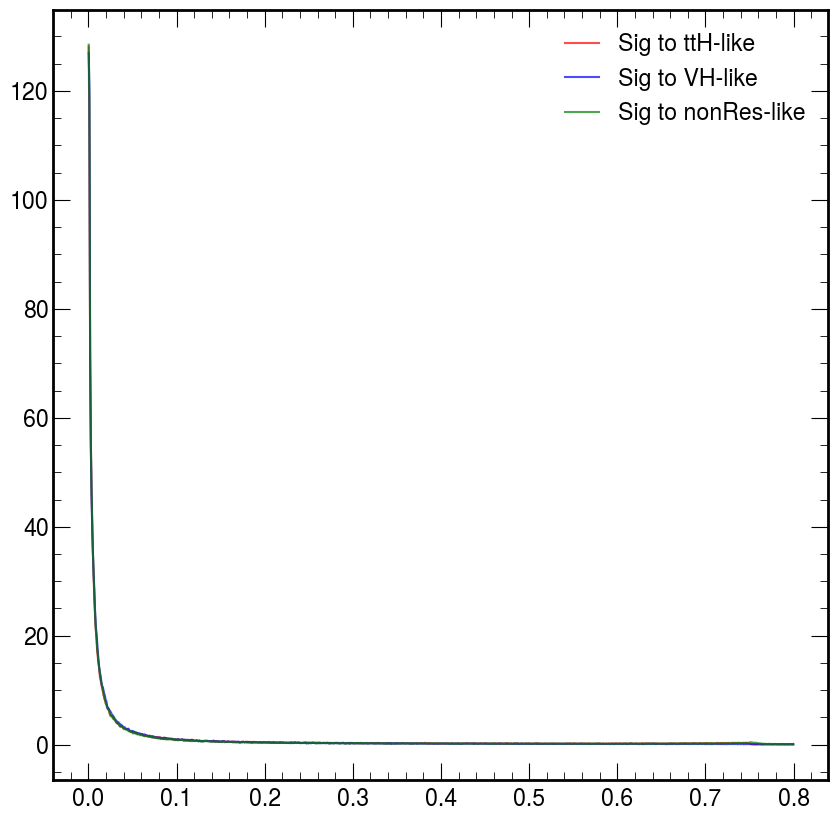

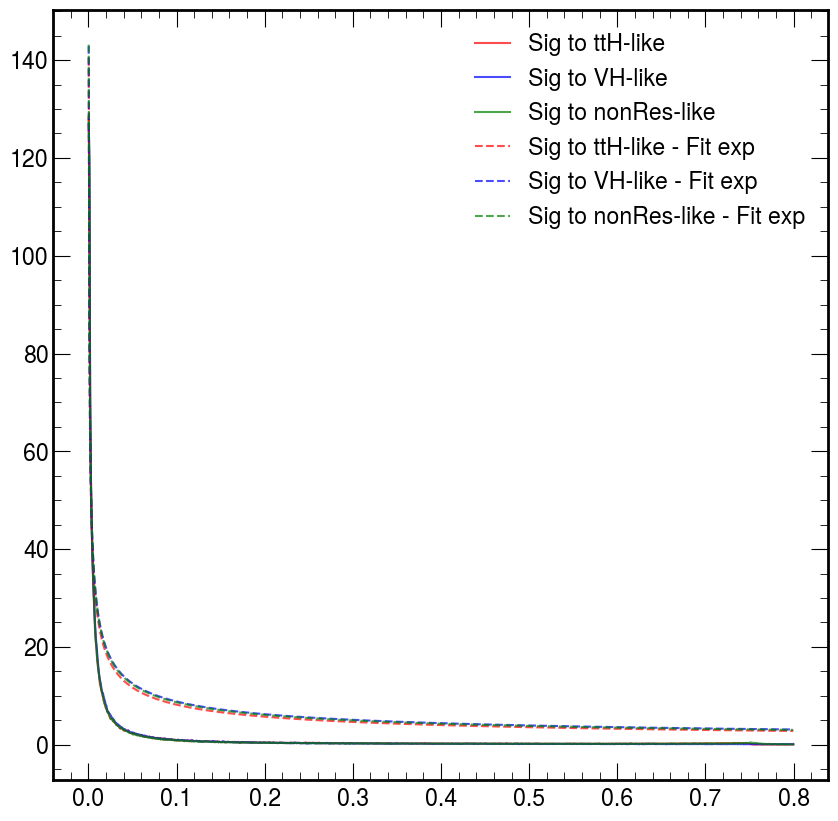

New configuration: [0.029384447152102457, 0.030981016006675285, 0.06530498552641793]
s = 1.1077431830868796, b = 217.08489067678659, s/√b = 0.07511999673107837 => -74.60912639539615
New configuration: [0.109895810839395, 0.003905313881958739, 7.273298084170154e-06]
both sig and bkg 0 at this hyperplane => 10000.0
New configuration: [0.004406731743988754, 0.032002364442433054, 0.06624256636734441]
s = 0.5779690051851228, b = 21.796156908129095, s/√b = 0.12325710407456518 => -122.19467186205536
New configuration: [0.18175582034595855, 0.1480754311468899, 0.07696092658077439]
s = 1.4017204769387857, b = 804.968137649321, s/√b = 0.04939080487431635 => -49.16226124740446
New configuration: [0.12927464989208917, 0.007015427942376225, 0.001176948105380515]
too little sig (0.24609590327395783) at this hyperplane => 0.0
New configuration: [0.0253483261558899, 0.03140306037458798, 0.02034538090988993]
s = 1.0583034336147503, b = 179.34376477611934, s/√b = 0.0789479349755655 => -78.44745731976775

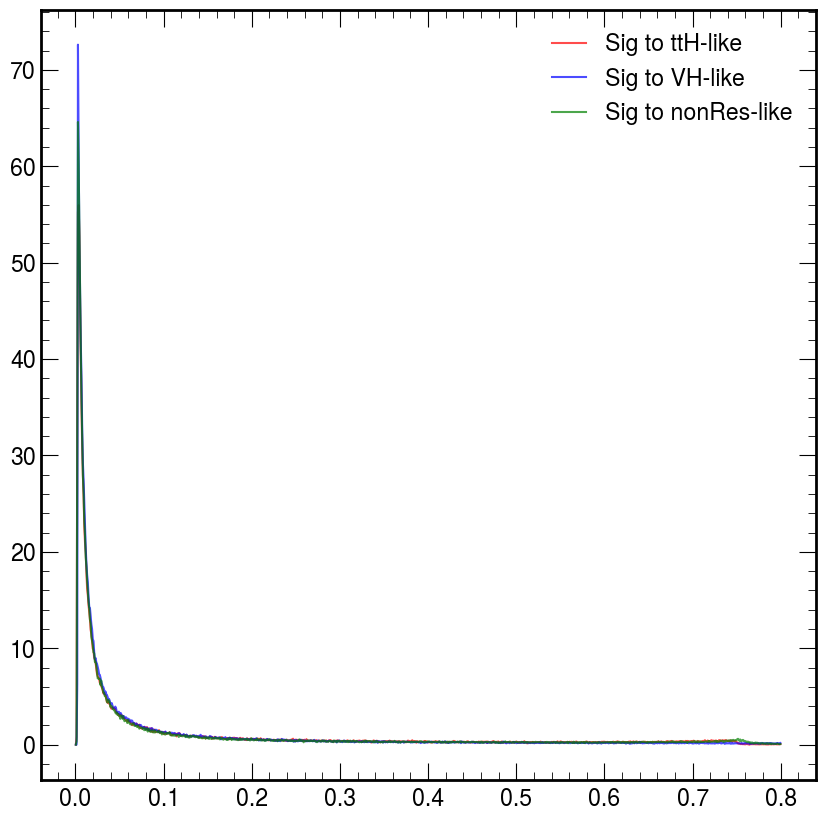

opt ttH levy values: c = 0.00870961681331182, $\mu$ = 0.00039999989780957745
opt VH levy values: c = 0.007883039576192, $\mu$ = 0.00039999984050452915
opt nonRes levy values: c = 0.008325919225327551, $\mu$ = 0.0003999998616005038


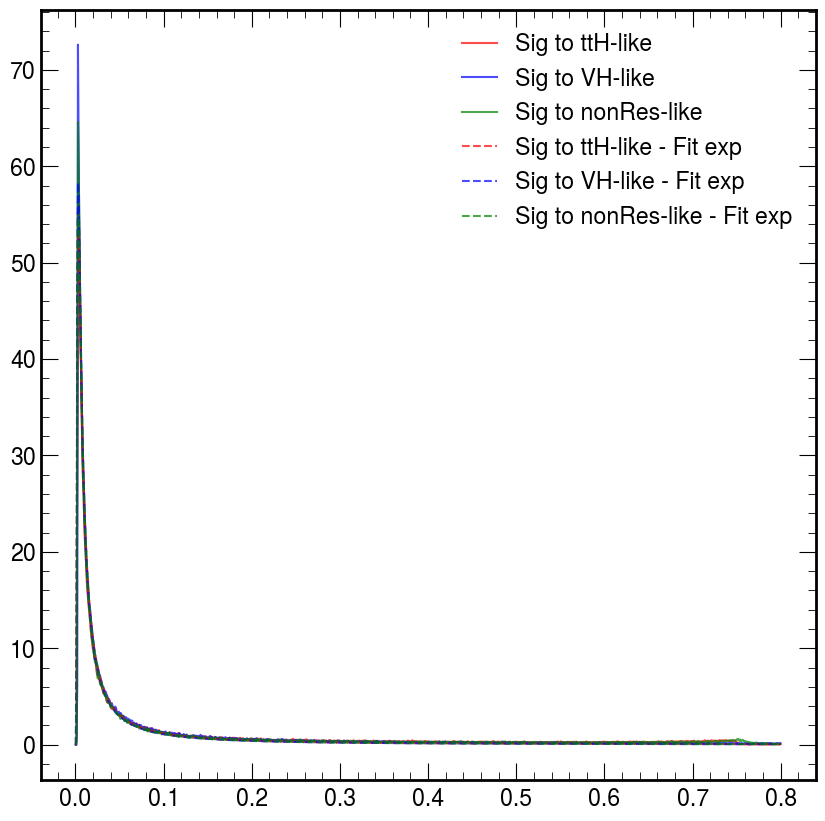

New configuration: [15.34437473851979, 0.001815051093041528, 0.03369598369989666]
both sig and bkg 0 at this hyperplane => 10000.0
New configuration: [0.05190737177308883, 0.013874331012765898, 0.010078370209168562]
s = 0.46704790370792315, b = 77.25063935517571, s/√b = 0.05308522346600194 => -52.74857389260993
New configuration: [0.12869565661797258, 0.010021556656254392, 0.004931464338478761]
too little sig (0.23962791358260865) at this hyperplane => 0.0
New configuration: [0.23217380641344243, 0.0059038962083019396, 3.410475749304141]
s = 0.25874619622529066, b = 20.899515223253555, s/√b = 0.05648243525051535 => -55.92014977997327
New configuration: [0.0181778567825372, 0.03904679927511131, 0.21979802197502063]
s = 0.6341501214859707, b = 169.4071355482261, s/√b = 0.04869177597057593 => -48.403376994832755
New configuration: [0.041909448056935354, 0.025121710097450883, 0.3551309547510664]
s = 0.7009254307142776, b = 172.77827361855253, s/√b = 0.053288562864940485 => -52.866100049002

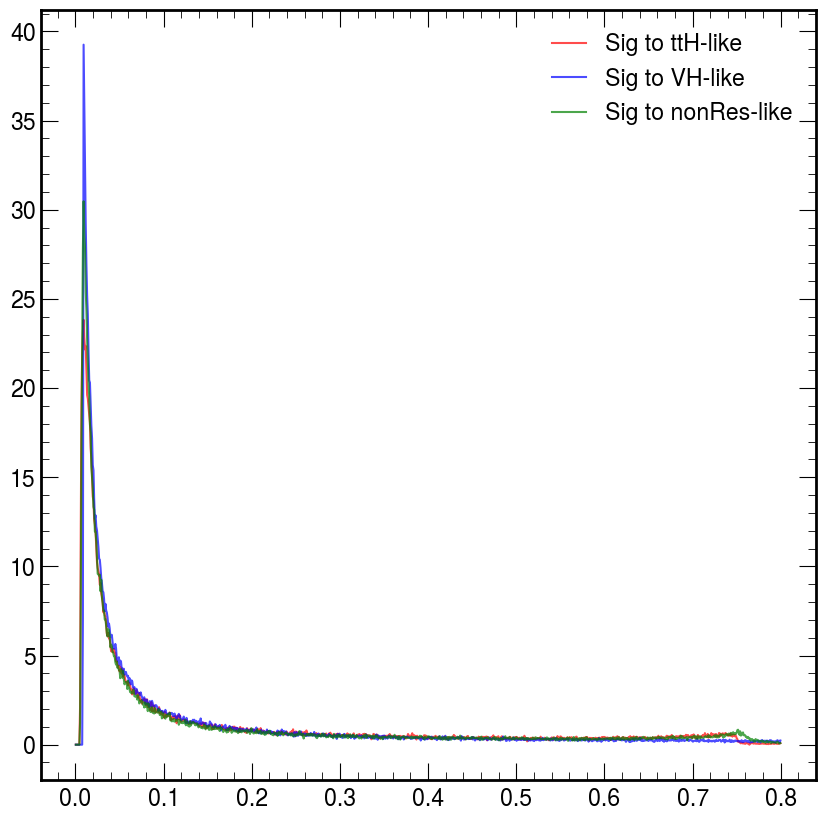

opt ttH levy values: c = 0.02167777495673499, $\mu$ = 0.0003999997717200853
opt VH levy values: c = 0.011179151831589232, $\mu$ = 0.0003999999892014727
opt nonRes levy values: c = 0.016957202140084993, $\mu$ = 0.0003999996682570891


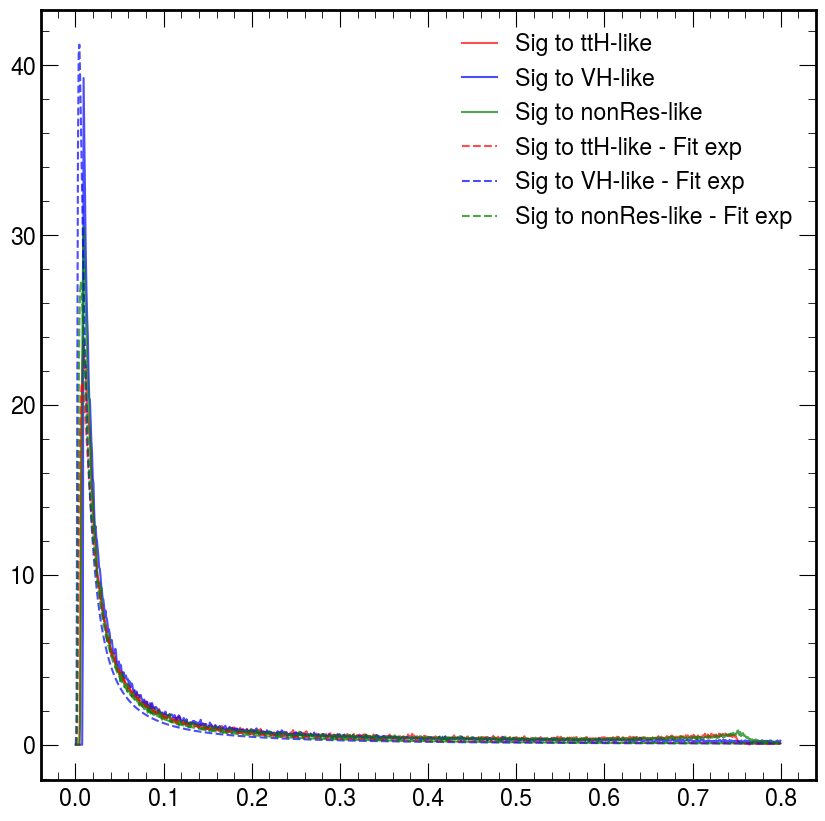

New configuration: [0.04818069328329712, 0.06860405132097312, 0.012917790068990555]
too little sig (0.1757890746186945) at this hyperplane => 0.0
New configuration: [0.13395349055514172, 0.004967637815477647, 0.011460195269524515]
both sig and bkg 0 at this hyperplane => 10000.0
New configuration: [0.046033299363129616, 0.002125147230006925, 0.27533111602789173]
both sig and bkg 0 at this hyperplane => 10000.0
New configuration: [0.12258281418727016, 0.0042583983266311675, 0.01739700316424424]
both sig and bkg 0 at this hyperplane => 10000.0
New configuration: [0.30644319739063436, 0.06265157401065674, 0.011241096378026436]
too little sig (0.13301917641339156) at this hyperplane => 0.0
New configuration: [0.10613146538294109, 0.002616546003135034, 0.7625919489668023]
both sig and bkg 0 at this hyperplane => 10000.0
New configuration: [0.017265500526959517, 0.02261456214088789, 0.014903284419673596]
too little sig (0.18666350289056705) at this hyperplane => 0.0
New configuration: [0.084

In [11]:
## NEED TO CHECK SERGO'S SUGGESTION: fix one axis (VH?) and try 2D optimization to see if it converges well to performance similar to Yibo's / 1D

plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "s_over_rootb_multiOptim")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# # x_preds, y_preds, z_preds = p_to_xyz(np.concatenate([BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(bdt_test_dict))], axis=0))
# for i, sample_name in enumerate(order):
#     if i == 0:
#         downsample = 100
#     elif i == 1:
#         downsample = 200
#     elif i == 2:
#         downsample = 400
#     elif i == 3:
#         downsample = 500

#     x_preds, y_preds, z_preds = p_to_xyz(
#         np.array(BDT_perf['ggF HH']['preds'][0])[bdt_test_dict[f"fold_0"].get_label() == i][::downsample],
#         split=True
#     )
#     ax.scatter(x_preds, y_preds, z_preds, marker='.', label=sample_name)
# plt.legend()
# plt.show()

# # plot s/√b curves
# for fold_idx in range(len(bdt_train_dict)):

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         clf_dict = multi_optimize_cut_boundaries(
#             BDT_perf['ggF HH']['preds'][fold_idx], 
#             bdt_test_dict[f"fold_{fold_idx}"].get_label() == 0, 
#             weights_plot_test[f"fold_{fold_idx}"],
#             min_sig=0.07
#         )

#     cat_dict = {}
#     for cat in range(len(clf_dict)):
#         prev_cat_slice = np.ones_like(weights_plot_test[f"fold_{fold_idx}"], dtype=bool)
#         if cat > 0:
#             for prev_cat in range(cat):
#                 prev_cat_slice = np.logical_and(
#                     prev_cat_slice,
#                     np.logical_not(
#                         np.all(
#                             p_to_xyz(np.array(BDT_perf['ggF HH']['preds'][fold_idx]), split=False) < clf_dict[prev_cat], 
#                             axis=1
#                         )
#                     )
#                 )
#         cat_dict[cat] = np.logical_and(
#             prev_cat_slice,
#             np.all(
#                 p_to_xyz(np.array(BDT_perf['ggF HH']['preds'][fold_idx]), split=False) < clf_dict[cat],
#                 axis=1
#             )
#         )

#     masses = data_test_aux_dict[f"fold_{fold_idx}"]['mass']
#     cat_num_samples = {}
#     for cat in range(len(clf_dict)):
#         cat_num_samples[cat] = {}
#         print('='*60)
#         print('='*60)
#         print(f"Fold {fold_idx}: Category {cat} (SVM) AND 120 GeV < m_HH < 130 GeV")
#         print('-'*60)
#         for m, sample_name in enumerate(order):
#             cat_num_samples[cat][sample_name] = np.sum(
#                 weights_plot_test[f"fold_{fold_idx}"][
#                     np.logical_and(  # event passes conditions and is the right type (i.e. sample)
#                         np.logical_and(  # event passes category and mass conditions
#                             cat_dict[cat],  # event passes category selections
#                             np.logical_and(  # diphoton mass is within 120-130 window
#                                 masses < 130,
#                                 masses > 120
#                             ),
#                         ),
#                         bdt_test_dict[f"fold_{fold_idx}"].get_label() == m
#                     )
#                 ]
#             )
#             print(f"{cat}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
#             print('-'*60)
#         print(f"{cat}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")

# print('='*60)
# print('='*60)
# print('='*60)
# print('='*60)

flat_preds = np.concatenate(BDT_perf['ggF HH']['preds'], axis=0)
flat_truths = np.concatenate([bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(bdt_test_dict))], axis=0)
flat_weights = np.concatenate([weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)
# flat_weights = np.concatenate([weight_test_dict[f"fold_{fold_idx}"] for fold_idx in range(len(bdt_test_dict))], axis=0)
flat_sample_names = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['sample_name'] for fold_idx in range(len(bdt_test_dict))], axis=0)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    clf_dict = multi_optimize_cut_boundaries(
        flat_preds, flat_truths, flat_weights, num_categories=3
    )

    # plot_s_over_root_b(
    #     sigs_and_bkgs['sig'], sigs_and_bkgs['bkg'], f"{sample_name} vs. {sample_name_ if sample_name_ != sample_name else 'all'}", 
    #     f"BDT_{sample_name}_vs_{sample_name_ if sample_name_ != sample_name else 'all'}_sOverRootb_withCuts_testData_sum", plot_dirpath, 
    #     weights=score_weights,
    #     lines=lines, lines_labels=line_labels, line_colors=line_colors
    # )

flat_mass = np.concatenate([data_test_aux_dict[f"fold_{fold_idx}"]['mass'] for fold_idx in range(len(data_test_aux_dict))], axis=0)
cat_dict = {}
for cat in range(len(clf_dict)):
    prev_cat_slice = np.ones_like(flat_weights, dtype=bool)
    if cat > 0:
        for prev_cat in range(cat):
            prev_cat_slice = np.logical_and(
                prev_cat_slice,
                np.logical_not(
                    np.all(
                        output_to_3d_thresholds(flat_preds, split=False) < clf_dict[prev_cat], 
                        axis=1
                    )
                )
            )
    cat_dict[cat] = np.logical_and(
        prev_cat_slice,
        np.all(
            output_to_3d_thresholds(flat_preds, split=False) < clf_dict[cat],
            axis=1
        )
    )

cat_num_samples = {}
for cat in range(len(clf_dict)):
    cat_num_samples[cat] = {}
    print('='*60)
    print('='*60)
    print(f"Category {cat+1} {f'3D outputs NOT< {clf_dict[cat-1]} AND ' if cat > 0 else ''}3D outputs < {clf_dict[cat]} AND 120 GeV < m_HH < 130 GeV")
    # print(f"Category {cat}: 3D outputs < {clf_dict[cat]:.4f} AND 120 GeV < m_HH < 130 GeV")
    print('-'*60)
    for m, sample_name in enumerate(order):
        sample_bool = np.logical_and(  # event passes conditions and is the right type (i.e. sample)
            np.logical_and(  # event passes category and mass conditions
                cat_dict[cat],  # event passes category selections
                np.logical_and(  # diphoton mass is within 120-130 window
                    flat_mass < 130,
                    flat_mass > 120
                ),
            ),
            flat_truths == m
        )
        cat_num_samples[cat][sample_name] = np.sum(
            flat_weights[sample_bool]
        )
        print(f"{cat+1}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
        print('-'*60)

        if sample_name == order[-1]:
            for smpl in [
                ['GluGluHToGG', 'GluGlutoHHto2B2G_kl_1p00_kt_1p00_c2_0p00'],
                ['VBFHToGG', 'VBFHToGG_M_125'],
                ['GGJets'], ['GJetPt20To40'], ['GJetPt40']
            ]:
                smpl_num = 0
                for smpl_ in smpl:
                    smpl_num += np.sum(
                        flat_weights[
                            np.logical_and(
                                sample_bool,
                                flat_sample_names == smpl_
                            )
                        ]
                    )
                print(f"{cat+1}: Num {smpl[0]} = {smpl_num:.4f}")
                print('-'*60)
        elif sample_name == order[-2]:
            smpl_num = np.sum(
                flat_weights[
                    np.logical_and(
                        sample_bool,
                        np.logical_or(
                            flat_sample_names == 'VHToGG',
                            flat_sample_names == 'VHtoGG_M_125'
                        )
                    )
                ]
            )
            print(f"{cat+1}: Num VH, no ZH or WH = {smpl_num:.4f}")
            print('-'*60)

        
    print(f"{cat+1}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")

cat_num_samples = {}
for cat in range(len(clf_dict)):
    cat_num_samples[cat] = {}
    print('='*60)
    print('='*60)
    print(f"Category {cat+1} {f'3D outputs NOT< {clf_dict[cat-1]} AND ' if cat > 0 else ''}3D outputs < {clf_dict[cat]}")
    # print(f"Category {cat}: 3D outputs < {clf_dict[cat]:.4f} AND 120 GeV < m_HH < 130 GeV")
    print('-'*60)
    for m, sample_name in enumerate(order):
        sample_bool = np.logical_and(  # event passes conditions and is the right type (i.e. sample)
            cat_dict[cat],  # event passes category selections
            flat_truths == m
        )
        cat_num_samples[cat][sample_name] = np.sum(
            flat_weights[sample_bool]
        )
        print(f"{cat+1}: Num {sample_name} = {cat_num_samples[cat][sample_name]:.4f}")
        print('-'*60)

        if sample_name == order[-1]:
            for smpl in [
                ['GluGluHToGG', 'GluGlutoHHto2B2G_kl_1p00_kt_1p00_c2_0p00'],
                ['VBFHToGG', 'VBFHToGG_M_125'],
                ['GGJets'], ['GJetPt20To40'], ['GJetPt40']
            ]:
                smpl_num = 0
                for smpl_ in smpl:
                    smpl_num += np.sum(
                        flat_weights[
                            np.logical_and(
                                sample_bool,
                                flat_sample_names == smpl_
                            )
                        ]
                    )
                print(f"{cat+1}: Num {smpl[0]} = {smpl_num:.4f}")
                print('-'*60)
        elif sample_name == order[-2]:
            smpl_num = np.sum(
                flat_weights[
                    np.logical_and(
                        sample_bool,
                        np.logical_or(
                            flat_sample_names == 'VHToGG',
                            flat_sample_names == 'VHtoGG_M_125'
                        )
                    )
                ]
            )
            print(f"{cat+1}: Num VH, no ZH or WH = {smpl_num:.4f}")
            print('-'*60)
    print(f"{cat+1}: S = {cat_num_samples[cat][order[0]]:.4f}, B = {np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]):.4f}, S/√B = {(cat_num_samples[cat][order[0]] / np.sqrt(np.sum([cat_num_samples[cat][order[v]] for v in range(1, len(order))]))):.4f}")

    


### Confusion Matrix

In [17]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "confusion_matrix")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

beta = 1
normalize = 'true'  # 'true' for normalize over rows, None for absoulte yields

for fold_idx in range(len(BDT_perf['ggF HH']['preds'])):

    pred_classes = np.argmax(BDT_perf['ggF HH']['preds'][fold_idx], axis=1)

    conf_matrix = confusion_matrix(
        bdt_test_dict[f"fold_{fold_idx}"].get_label(), 
        pred_classes,
        sample_weight=weights_plot_test[f"fold_{fold_idx}"],
        normalize=normalize
    )

    plot_confusion_matrix(
        conf_matrix, order, f"confusion_matrix_fold{fold_idx}{'_norm_'+normalize if normalize is not None else ''}", plot_dirpath
    )

    f1_scores = fbeta_score(
        bdt_test_dict[f"fold_{fold_idx}"].get_label(), 
        pred_classes,
        beta=beta,
        sample_weight=weights_plot_test[f"fold_{fold_idx}"], average=None
    )
    print(f"fold {fold_idx}: Fβ (β={beta}) score = \n{f1_scores}")

full_pred_classes = np.argmax(
    np.concatenate(
        [
            BDT_perf['ggF HH']['preds'][fold_idx] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
        ]
    ), axis=1
)
full_labels = np.concatenate(
    [
        bdt_test_dict[f"fold_{fold_idx}"].get_label() for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
    ]
)
full_weights = np.concatenate(
    [
        weights_plot_test[f"fold_{fold_idx}"] for fold_idx in range(len(BDT_perf['ggF HH']['preds']))
    ]
)

conf_matrix = confusion_matrix(
    full_labels, 
    full_pred_classes,
    sample_weight=full_weights,
    normalize=normalize
)

plot_confusion_matrix(
    conf_matrix, order, f"confusion_matrix_sum{'_norm_'+normalize if normalize is not None else ''}", plot_dirpath
)

f1_scores = fbeta_score(
    full_labels, 
    full_pred_classes,
    beta=beta,
    sample_weight=full_weights, average=None
)
print(f"Sum over folds: Fβ (β={beta}) score = \n{f1_scores}")


fold 0: Fβ (β=1) score = 
[8.05096023e-04 9.91778315e-02 2.77143007e-02 9.65218150e-01]
fold 1: Fβ (β=1) score = 
[8.22758477e-04 9.67405147e-02 3.55405348e-02 9.65809529e-01]
fold 2: Fβ (β=1) score = 
[8.08195007e-04 9.93985569e-02 4.48444098e-02 9.65684605e-01]
fold 3: Fβ (β=1) score = 
[8.08775905e-04 1.01702786e-01 2.29477049e-02 9.65707848e-01]
fold 4: Fβ (β=1) score = 
[7.81900652e-04 1.06376705e-01 3.45762970e-02 9.64912907e-01]
Sum over folds: Fβ (β=1) score = 
[8.05168965e-04 1.00560812e-01 3.19487312e-02 9.65466005e-01]


<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

### Variable Importance

In [18]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "variable_importance")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

full_score_dict = {}
for fold_idx in range(len(bdt_train_dict)):
    booster = xgb.Booster(param, model_file=os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    labels = copy.deepcopy([key for key in hlf_vars_columns_dict[f'fold_{fold_idx}'].keys()])
    labels.sort()
    
    booster.feature_names = labels
    # score_dict = booster.get_score(importance_type='total_gain')
    score_dict = booster.get_score()
    if fold_idx == 0:
        full_score_dict = copy.deepcopy(score_dict)
    else:
        for key in full_score_dict.keys():
            full_score_dict[key] += score_dict[key]

    sorted_scores, sorted_labels = [], []
    for label, score in score_dict.items():
        sorted_scores.append(score)
        sorted_labels.append(label)

    sorted_labels = np.array(sorted_labels)[np.argsort(sorted_scores)]
    sorted_scores = np.sort(sorted_scores)

    plot_feature_importance(
        sorted_scores, sorted_labels, f'xgb_importance_fold{fold_idx}', plot_dirpath
    )

full_sorted_scores, full_sorted_labels = [], []
for label, score in full_score_dict.items():
    full_sorted_scores.append(score / len(bdt_train_dict))
    full_sorted_labels.append(label)

full_sorted_labels = np.array(full_sorted_labels)[np.argsort(full_sorted_scores)]
full_sorted_scores = np.sort(full_sorted_scores)

plot_feature_importance(
    full_sorted_scores, full_sorted_labels, f'xgb_importance_sum', plot_dirpath
)

[12:46:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:46:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:46:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" 

### Input Variable Correlation

In [19]:
data_corr_dict = {}
for fold_idx in range(len(data_aux_dict)):
    merged_pd = copy.deepcopy(data_df_dict[f"fold_{fold_idx}"])
    # for i, var_name in enumerate(['mass']):
    for i, var_name in enumerate(['HHbbggCandidate_mass']):
        merged_pd.insert(i, var_name, data_aux_dict[f"fold_{fold_idx}"].loc[:, var_name])
    signal_merged_pd = merged_pd.loc[data_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == 'GluGluToHH']
    data_corr_dict[f"fold_{fold_idx}"] = signal_merged_pd.corr()

    # print(f"fold {fold_idx}")
    # print('-'*60)
    # print(data_corr_dict[f"fold_{fold_idx}"].iloc[0, :])
    # print(f"{'='*60}\n{'='*60}\n{'='*60}\n")

print('averaged correlation')
print('-'*60)
corr_cols = data_corr_dict[f"fold_0"].columns
avg_cols = data_corr_dict[f"fold_0"].iloc[0, :].to_numpy(copy=True)
for fold_idx in range(1, len(data_corr_dict)):
    avg_cols += data_corr_dict[f"fold_{fold_idx}"].iloc[0, :].to_numpy(copy=True)
avg_cols /= len(data_corr_dict)
avg_cols /= avg_cols[0]

sorted_avg_corr = np.argsort(np.abs(avg_cols))[::-1]
for i in sorted_avg_corr:
    print(f"{corr_cols[i]}: {avg_cols[i]:.4f}")

averaged correlation
------------------------------------------------------------
HHbbggCandidate_mass: 1.0000
pt_balance: -0.1798
HHbbggCandidate_pt: 0.1444
sublead_bjet_btagPNetB: 0.1235
lead_sigmaE_over_E: -0.1131
sublead_sigmaE_over_E: -0.0842
lead_bjet_btagPNetB: 0.0810
puppiMET_pt: 0.0751
n_jets: 0.0549
sublead_mvaID: 0.0353
lead_mvaID: 0.0333
chi_t0: 0.0265
chi_t1: 0.0187
lead_bjet_eta: 0.0046
CosThetaStar_jj: 0.0046
leadBjet_leadLepton: -0.0037
lepton1_mvaID: -0.0037
lepton1_pfIsoId: -0.0037
lepton1_pt: -0.0036
eta: 0.0030
CosThetaStar_gg: 0.0030
HHbbggCandidate_eta: 0.0024
CosThetaStar_CS: -0.0018
DeltaPhi_j1MET: -0.0016
DeltaPhi_j2MET: 0.0015
DeltaPhi_isr_jet_z: 0.0012
DeltaPhi_jj: -0.0008
sublead_bjet_eta: 0.0001


### Mass Sculpting

In [20]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "mass_sculpting")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "PNetBtag_sculpting")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

if 'BDT_perf' not in globals():
    with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_perf.json"), 'r') as f:
        BDT_perf = json.load(f)

score_cuts = [0.0, 0.7, 0.99, 0.9955]
label_arr = [f'score above {score_cut}' for score_cut in score_cuts]
plot_vars = ['mass', 'dijet_mass', 'HHbbggCandidate_mass']
# plot_vars = ['lead_bjet_btagPNetB', 'sublead_bjet_btagPNetB']


# for bool_arr in [nonres_bool]:
for idx, sample_name_bool in enumerate(["GluGluToHH", "GluGlutoHHto2B2G_kl_0p00_kt_1p00_c2_0p00", "GluGlutoHHto2B2G_kl_5p00_kt_1p00_c2_0p00"]):

    # nonres_bool = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GGJets") | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GJetPt40")

    # Loop over and plot the per-fold variables
    for fold_idx in range(len(hlf_vars_columns_dict)):

        bool_arr = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == sample_name_bool)

        pass_cut_bools = [
            np.array(BDT_perf['ggF HH']['preds'][fold_idx])[:, 0] > score_cut for score_cut in score_cuts
        ]

        masks = [
            np.logical_and(bool_arr, pass_cut_bool) for pass_cut_bool in pass_cut_bools
        ]
        
        for var_idx, var_name in enumerate(plot_vars):

            plot_dirpath_ = os.path.join(plot_dirpath, var_name)
            if not os.path.exists(plot_dirpath_):
                os.makedirs(plot_dirpath_)

            sculpting_hists = [
                hist.Hist(VARIABLES[var_name]).fill(
                    var=data_test_aux_dict[f"fold_{fold_idx}"].loc[mask, var_name]
                    # var=data_test_df_dict[f"fold_{fold_idx}"].loc[mask, var_name]
                ) for mask in masks
            ]
        
            make_input_plot(
                plot_dirpath_, var_name,
                sculpting_hists, 
                fold_idx=fold_idx, labels=label_arr, 
                plot_prefix=f'test_signal{idx}_scoreCut_', num_compare=1
            )

    # flattened sculpting check
    # flat_bool = np.concatenate([
    #     (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'].to_numpy(copy=True) == "GGJets") 
    #     | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'].to_numpy(copy=True) == "GJetPt20To40") 
    #     | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'].to_numpy(copy=True) == "GJetPt40")
    #     for fold_idx in range(len(data_test_aux_dict))
    # ])
    flat_bool = np.concatenate([
        data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == sample_name_bool
        for fold_idx in range(len(data_test_aux_dict))
    ])
    
    flat_pass_cut_bools = [
        np.concatenate(BDT_perf['ggF HH']['preds'], axis=0)[:, 0] > score_cut for score_cut in score_cuts
    ]
    flat_masks = [
        np.logical_and(flat_bool, flat_pass_cut_bool) for flat_pass_cut_bool in flat_pass_cut_bools
    ]

    for var_idx, var_name in enumerate(plot_vars):
        flat_var = np.concatenate([
            data_test_aux_dict[f"fold_{fold_idx}"].loc[:, var_name].to_numpy(copy=True) for fold_idx in range(len(data_test_aux_dict))
            # data_test_df_dict[f"fold_{fold_idx}"].loc[:, var_name].to_numpy(copy=True) for fold_idx in range(len(data_test_df_dict))
        ])

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        flat_sculpting_hists = [
            hist.Hist(VARIABLES[var_name]).fill(var=flat_var[mask]) for mask in flat_masks
        ]

        make_input_plot(
            plot_dirpath_, var_name,
            flat_sculpting_hists, 
            fold_idx=None, labels=label_arr, 
            plot_prefix=f'test_signal{idx}_scoreCut_', num_compare=1
        )

### Resampling for Mass Sculpting

In [19]:
def resample_from_var(
    sample_var, sample_weight, n_events, 
    min_value=None,
    n_samples_per_event=1, bins=100, seed=None
):
    resample_rng = np.random.default_rng(seed=seed)

    np_hist, bin_edges = np.histogram(sample_var, bins=bins, weights=sample_weight, density=True)
    np_hist /= np.sum(np_hist)

    bin_choices = resample_rng.choice(np.arange(len(np_hist)), size=n_events*n_samples_per_event, p=np_hist)

    value_choices = (bin_edges[bin_choices+1] - bin_edges[bin_choices]) * resample_rng.random(size=n_events*n_samples_per_event) + bin_edges[bin_choices]

    if min_value is None or np.all(value_choices > min_value):
        return value_choices
    else:  # this is not really correct, just an approximation to make the code work faster
        bad_choices_bool = value_choices <= min_value

        largest_min_value = np.max(min_value[bad_choices_bool])

        np_hist, bin_edges = np.histogram(sample_var[sample_var > largest_min_value], bins=bins, weights=sample_weight[sample_var > largest_min_value], density=True)
        np_hist /= np.sum(np_hist)

        bin_choices = resample_rng.choice(np.arange(len(np_hist)), size=np.sum(bad_choices_bool), p=np_hist)
        
        value_choices[bad_choices_bool] = (bin_edges[bin_choices+1] - bin_edges[bin_choices]) * resample_rng.random(size=np.sum(bad_choices_bool)) + bin_edges[bin_choices]
        
        return value_choices

def resample_grow_np(var, bool_arr, n_duplicates_per_event):
    new_rows_shape = tuple([n_duplicates_per_event]+[1 for _ in range(1, len(np.shape(var)))])
    new_rows = np.tile(
        var[bool_arr],
        new_rows_shape
    )
    return np.concatenate([var, new_rows])
def resample_grow_pd(var, bool_arr, n_duplicates_per_event):
    new_rows = pd.DataFrame(
        np.tile(
            ( var.loc[bool_arr] ).to_numpy(),
            (n_duplicates_per_event, 1)
        ),
        columns=var.columns
    )
    return pd.concat([var, new_rows], ignore_index=True)
        

In [ ]:
resample_ = 10
RESAMPLE = (resample_) * 10  # Set to False for no resampling, otherwise sets the number of times to duplicate gjet data for resampling

plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "mass_sculpting_resample_single")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

score_cuts = [0.0, 0.7, 0.99, 0.9955]
label_arr = [f'score above {score_cut}' for score_cut in score_cuts]
plot_vars = ['mass', 'dijet_mass', 'HHbbggCandidate_mass']

BDT_perf_resample = [
    {
        f'preds{score_cut}': copy.deepcopy({plot_var: list() for plot_var in plot_vars+['event']}) for score_cut in score_cuts
    } for fold_idx in range(len(bdt_train_dict))
]

for fold_idx in range(len(bdt_train_dict)):
    booster = xgb.Booster(param)
    booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    nonres_bool = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GGJets") | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GJetPt40")

    data_hlf_test = resample_grow_np(data_hlf_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    data_test_aux = resample_grow_pd(data_test_aux_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    weight_test = resample_grow_np(weight_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    weights_plot = resample_grow_np(weights_plot_test[f"fold_{fold_idx}"], nonres_bool, resample_)
    xgb_label_test = resample_grow_np(xgb_label_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)

    gg_bool = (data_test_aux.loc[:, 'sample_name'] == "GGJets")
    tth_bool = (data_test_aux.loc[:, 'sample_name'] == "ttHToGG")
    gj_bool = (data_test_aux.loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt40")
    nonres_bool = (data_test_aux.loc[:, 'sample_name'] == "GGJets") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt40")


    for _ in range(RESAMPLE // resample_):

        for particle_type in ['lead', 'sublead']:

            gg_mvaID = data_hlf_test[
                gg_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_mvaID"]
            ]
            data_hlf_test[
                gj_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_mvaID"]
            ] = resample_from_var(
                gg_mvaID, 
                weights_plot[gg_bool],
                np.sum(gj_bool),
                bins=190
            )

            tth_pNetB = data_hlf_test[
                tth_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_bjet_btagPNetB"]
            ]
            data_hlf_test[
                nonres_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_bjet_btagPNetB"]
            ] = resample_from_var(
                tth_pNetB, 
                np.abs(weights_plot[tth_bool]),
                np.sum(nonres_bool),
                bins=100,
                min_value=data_test_aux.loc[nonres_bool, "max_nonbjet_btag"].to_numpy()
            )

        nonres_ggf_preds = booster.predict(
            xgb.DMatrix(
                data=data_hlf_test[nonres_bool], label=xgb_label_test[nonres_bool], 
                weight=np.abs(weight_test)[nonres_bool],
                missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
            ), 
            iteration_range=(0, booster.best_iteration+1)
        )[:, 0]
        
        for score_cut in score_cuts:
            if (
                len(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_vars[0]]) > 0 
                and len(np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_vars[0]])) >= 1000
            ):
                continue

            new_unique_eventNumber = np.setdiff1d(
                data_test_aux.loc[nonres_bool, "event"].to_numpy()[nonres_ggf_preds > score_cut],
                BDT_perf_resample[fold_idx][f'preds{score_cut}']["event"]
            )
            
            if len(new_unique_eventNumber) > 0:
                BDT_perf_resample[fold_idx][f'preds{score_cut}']["event"].extend(new_unique_eventNumber.tolist())

                intersect, comm1, comm2 = np.intersect1d(
                    data_test_aux.loc[nonres_bool, "event"].to_numpy()[nonres_ggf_preds > score_cut],
                    new_unique_eventNumber,
                    return_indices=True
                )

                intersect_bool = np.zeros_like(
                    data_test_aux.loc[nonres_bool, "event"].to_numpy()[nonres_ggf_preds > score_cut], 
                    dtype=bool
                )
                for index in comm1:
                    intersect_bool[index] = True
                
                for var_idx, plot_var in enumerate(plot_vars):
                    BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var].append(
                        data_test_aux.loc[nonres_bool, plot_var].to_numpy()[nonres_ggf_preds > score_cut][intersect_bool]
                    )
                
    for var_idx, plot_var in enumerate(plot_vars):

        plot_dirpath_ = os.path.join(plot_dirpath, plot_var)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)
        
        test_hists = [hist.Hist(VARIABLES[plot_var]).fill(var=np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var])) for score_cut in score_cuts]
        make_input_plot(
            plot_dirpath_, plot_var,
            test_hists, 
            fold_idx=fold_idx, labels=label_arr, 
            plot_prefix='test_non-res_scoreCut_'
        )

for var_idx, plot_var in enumerate(plot_vars):

    plot_dirpath_ = os.path.join(plot_dirpath, plot_var)
    if not os.path.exists(plot_dirpath_):
        os.makedirs(plot_dirpath_)

    test_hists = [hist.Hist(VARIABLES[plot_var]).fill(
        var=np.concatenate(
            [np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var]) for fold_idx in range(len(BDT_perf_resample))]
        )
    ) for score_cut in score_cuts]
    make_input_plot(
        plot_dirpath_, plot_var,
        test_hists, 
        fold_idx=None, labels=label_arr, 
        plot_prefix='test_non-res_scoreCut_'
    )


[15:17:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:26:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:34:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117937192/work/src/learner.cc:576: 
Parameters: { "device" 

: 

In [ ]:
resample_ = 10
RESAMPLE = (resample_) * 10  # Set to False for no resampling, otherwise sets the number of times to duplicate gjet data for resampling

plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "kl_mass_sculpting_resample_single")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

score_cuts = [0.0, 0.7, 0.99, 0.9955]
label_arr = [f'score above {score_cut}' for score_cut in score_cuts]
plot_vars = ['mass', 'dijet_mass', 'HHbbggCandidate_mass']

BDT_perf_resample = [
    {
        f'preds{score_cut}': copy.deepcopy({plot_var: list() for plot_var in plot_vars+['event']}) for score_cut in score_cuts
    } for fold_idx in range(len(bdt_train_dict))
]

for fold_idx in range(len(bdt_train_dict)):
    booster = xgb.Booster(param)
    booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

    SM_bool = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GluGluToHH")
    kl0_bool = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GluGlutoHHto2B2G_kl_0p00_kt_1p00_c2_0p00")
    kl5_bool = (data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'sample_name'] == "GluGlutoHHto2B2G_kl_5p00_kt_1p00_c2_0p00")

    for bool_arr in [SM_bool, kl0_bool, kl5_bool]:

    data_hlf_test = resample_grow_np(data_hlf_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    data_test_aux = resample_grow_pd(data_test_aux_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    weight_test = resample_grow_np(weight_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)
    weights_plot = resample_grow_np(weights_plot_test[f"fold_{fold_idx}"], nonres_bool, resample_)
    xgb_label_test = resample_grow_np(xgb_label_test_dict[f"fold_{fold_idx}"], nonres_bool, resample_)

    gg_bool = (data_test_aux.loc[:, 'sample_name'] == "GGJets")
    tth_bool = (data_test_aux.loc[:, 'sample_name'] == "ttHToGG")
    gj_bool = (data_test_aux.loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt40")
    nonres_bool = (data_test_aux.loc[:, 'sample_name'] == "GGJets") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt20To40") | (data_test_aux.loc[:, 'sample_name'] == "GJetPt40")


    for _ in range(RESAMPLE // resample_):

        for particle_type in ['lead', 'sublead']:

            gg_mvaID = data_hlf_test[
                gg_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_mvaID"]
            ]
            data_hlf_test[
                gj_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_mvaID"]
            ] = resample_from_var(
                gg_mvaID, 
                weights_plot[gg_bool],
                np.sum(gj_bool),
                bins=190
            )

            tth_pNetB = data_hlf_test[
                tth_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_bjet_btagPNetB"]
            ]
            data_hlf_test[
                nonres_bool, 
                hlf_vars_columns_dict[f"fold_{fold_idx}"][f"{particle_type}_bjet_btagPNetB"]
            ] = resample_from_var(
                tth_pNetB, 
                np.abs(weights_plot[tth_bool]),
                np.sum(nonres_bool),
                bins=100,
                min_value=data_test_aux.loc[nonres_bool, "max_nonbjet_btag"].to_numpy()
            )

        nonres_ggf_preds = booster.predict(
            xgb.DMatrix(
                data=data_hlf_test[nonres_bool], label=xgb_label_test[nonres_bool], 
                weight=np.abs(weight_test)[nonres_bool],
                missing=-999.0, feature_names=list(hlf_vars_columns_dict[f"fold_{fold_idx}"])
            ), 
            iteration_range=(0, booster.best_iteration+1)
        )[:, 0]
        
        for score_cut in score_cuts:
            if (
                len(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_vars[0]]) > 0 
                and len(np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_vars[0]])) >= 1000
            ):
                continue

            new_unique_eventNumber = np.setdiff1d(
                data_test_aux.loc[nonres_bool, "event"].to_numpy()[nonres_ggf_preds > score_cut],
                BDT_perf_resample[fold_idx][f'preds{score_cut}']["event"]
            )
            
            if len(new_unique_eventNumber) > 0:
                BDT_perf_resample[fold_idx][f'preds{score_cut}']["event"].extend(new_unique_eventNumber.tolist())

                intersect, comm1, comm2 = np.intersect1d(
                    data_test_aux.loc[nonres_bool, "event"].to_numpy()[nonres_ggf_preds > score_cut],
                    new_unique_eventNumber,
                    return_indices=True
                )

                intersect_bool = np.zeros_like(
                    data_test_aux.loc[nonres_bool, "event"].to_numpy()[nonres_ggf_preds > score_cut], 
                    dtype=bool
                )
                for index in comm1:
                    intersect_bool[index] = True
                
                for var_idx, plot_var in enumerate(plot_vars):
                    BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var].append(
                        data_test_aux.loc[nonres_bool, plot_var].to_numpy()[nonres_ggf_preds > score_cut][intersect_bool]
                    )
                
    for var_idx, plot_var in enumerate(plot_vars):

        plot_dirpath_ = os.path.join(plot_dirpath, plot_var)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)
        
        test_hists = [hist.Hist(VARIABLES[plot_var]).fill(var=np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var])) for score_cut in score_cuts]
        make_input_plot(
            plot_dirpath_, plot_var,
            test_hists, 
            fold_idx=fold_idx, labels=label_arr, 
            plot_prefix='test_non-res_scoreCut_'
        )

for var_idx, plot_var in enumerate(plot_vars):

    plot_dirpath_ = os.path.join(plot_dirpath, plot_var)
    if not os.path.exists(plot_dirpath_):
        os.makedirs(plot_dirpath_)

    test_hists = [hist.Hist(VARIABLES[plot_var]).fill(
        var=np.concatenate(
            [np.concatenate(BDT_perf_resample[fold_idx][f'preds{score_cut}'][plot_var]) for fold_idx in range(len(BDT_perf_resample))]
        )
    ) for score_cut in score_cuts]
    make_input_plot(
        plot_dirpath_, plot_var,
        test_hists, 
        fold_idx=None, labels=label_arr, 
        plot_prefix='test_non-res_scoreCut_'
    )


### Pre-Standardization

In [ ]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "pre_std")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttH + bbH"]+" train", MC_NAMES_PRETTY["ttH + bbH"]+" val", MC_NAMES_PRETTY["ttH + bbH"]+" test",
    # MC_NAMES_PRETTY["single-H"]+" train", MC_NAMES_PRETTY["single-H"]+" val", MC_NAMES_PRETTY["single-H"]+" test",
    # MC_NAMES_PRETTY["non-res"]+" train", MC_NAMES_PRETTY["non-res"]+" val", MC_NAMES_PRETTY["non-res"]+" test",
    MC_NAMES_PRETTY["VH"]+" train", MC_NAMES_PRETTY["VH"]+" val", MC_NAMES_PRETTY["VH"]+" test",
    MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" train", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" val", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" test",
]
# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_name in hlf_vars_columns_dict['fold_0']:
        if var_name in {'puppiMET_eta'}:
            continue

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):
            train_mask = xgb_label_train_dict[f'fold_{fold_idx}'] == i
            val_mask = xgb_label_val_dict[f'fold_{fold_idx}'] == i
            test_mask = xgb_label_test_dict[f'fold_{fold_idx}'] == i

            train_np = (
                data_df_dict[f'fold_{fold_idx}'].iloc[train_idxs_dict[f'fold_{fold_idx}']]
            ).loc[train_mask, var_name].to_numpy(dtype=int)
            val_np = (
                data_df_dict[f'fold_{fold_idx}'].iloc[val_idxs_dict[f'fold_{fold_idx}']]
            ).loc[val_mask, var_name].to_numpy(dtype=int)
            test_np = data_test_df_dict[f'fold_{fold_idx}'].loc[test_mask, var_name].to_numpy(dtype=int)

            train_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=train_np)
            val_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=val_np)
            test_hists[sample_name] = hist.Hist(VARIABLES[var_name]).fill(var=test_np)
    
            make_input_plot(
                plot_dirpath_, var_name,
                [train_hists[sample_name], val_hists[sample_name], test_hists[sample_name]], 
                fold_idx=fold_idx, labels=label_arr_fold[3*i : 3*(i+1)], plot_prefix=f'train_val_test_{sample_name}_'
            )
        for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
            if re.search('epton', var_name) is not None:
                reduced_order = order[1:]
                reduced_label_arr = label_arr_fold[j+3::3]
            else:
                reduced_order = order
                reduced_label_arr = label_arr_fold[j::3]
            make_input_plot(
                plot_dirpath_, var_name,
                [histdict[sample_name] for sample_name in reduced_order], 
                fold_idx=fold_idx, labels=reduced_label_arr, plot_prefix=plot_type
            )


/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multi

### Post-Standardization

In [12]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "post_std")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

label_arr_fold = [
    MC_NAMES_PRETTY["GluGluToHH"]+" train", MC_NAMES_PRETTY["GluGluToHH"]+" val", MC_NAMES_PRETTY["GluGluToHH"]+" test",
    MC_NAMES_PRETTY["ttHToGG"]+" train", MC_NAMES_PRETTY["ttHToGG"]+" val", MC_NAMES_PRETTY["ttHToGG"]+" test",
    # MC_NAMES_PRETTY["single-H"]+" train", MC_NAMES_PRETTY["single-H"]+" val", MC_NAMES_PRETTY["single-H"]+" test",
    # MC_NAMES_PRETTY["non-res"]+" train", MC_NAMES_PRETTY["non-res"]+" val", MC_NAMES_PRETTY["non-res"]+" test",
    MC_NAMES_PRETTY["VH"]+" train", MC_NAMES_PRETTY["VH"]+" val", MC_NAMES_PRETTY["VH"]+" test",
    MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" train", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" val", MC_NAMES_PRETTY["non-res + ggFH + VBFH"]+" test",
]
# Loop over and plot the per-fold variables
for fold_idx in range(len(hlf_vars_columns_dict)):

    for var_idx, var_name in enumerate(hlf_vars_columns_dict['fold_0']):
        if var_name in {'puppiMET_eta'}:
            continue

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        train_hists, val_hists, test_hists = {}, {}, {}
        for i, sample_name in enumerate(order):
            train_mask = xgb_label_train_dict[f'fold_{fold_idx}'] == i
            val_mask = xgb_label_val_dict[f'fold_{fold_idx}'] == i
            test_mask = xgb_label_test_dict[f'fold_{fold_idx}'] == i

            train_np = train_data_dict[f'fold_{fold_idx}'][train_mask, var_idx]
            val_np = val_data_dict[f'fold_{fold_idx}'][val_mask, var_idx]
            test_np = data_hlf_test_dict[f'fold_{fold_idx}'][test_mask, var_idx]

            train_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=train_np)
            val_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=val_np)
            test_hists[sample_name] = hist.Hist(VARIABLES_STD[var_name]).fill(var=test_np)
    
            make_input_plot(
                plot_dirpath_, var_name,
                [train_hists[sample_name], val_hists[sample_name], test_hists[sample_name]], 
                fold_idx=fold_idx, labels=label_arr_fold[3*i : 3*(i+1)], plot_prefix=f'train_val_test_{sample_name}_'
            )
        for j, (plot_type, histdict) in enumerate([('train_', train_hists), ('val_', val_hists), ('test_', test_hists)]):
            make_input_plot(
                plot_dirpath_, var_name,
                [histdict[sample_name] for sample_name in order], 
                fold_idx=fold_idx, labels=label_arr_fold[j::3], plot_prefix=plot_type
            )

/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multi

### Save out new parquets for Yibo to run

In [13]:
# EVAL_DATA_ON_ALL_FOLDS = True
NONRES_sideband = False

PLOT_DATA = True
PLOT_NONRES = True

# load and pre-process the data
if 'DATA_data_df_dict' not in globals() and PLOT_DATA:
    DATA_FILEPATHS_DICT = {
        'Data': [
            # 2022
            lpc_fileprefix+Run3_2022[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/DataC_2022/*output.parquet",
            lpc_fileprefix+Run3_2022[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/DataD_2022/*output.parquet",
            lpc_fileprefix+Run3_2022[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraE/*output.parquet",
            lpc_fileprefix+Run3_2022[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraF/*output.parquet",
            lpc_fileprefix+Run3_2022[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraG/*output.parquet",
            # 2023
            lpc_fileprefix+Run3_2023[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraCv1/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraCv2/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraCv3/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraCv4/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraDv1/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+"_MultiBDT_output_mvaIDCorr_22_23/data/Data_EraDv2/*output.parquet",
        ]
    }
    (
        NOTHING_IGNORE,
        DATA_data_df_dict, DATA_data_test_df_dict, 
        DATA_data_hlf_dict, DATA_label_dict,
        DATA_data_hlf_test_dict, DATA_label_test_dict, 
        DATA_hlf_vars_columns_dict,
        DATA_data_aux_dict, DATA_data_test_aux_dict
    ) = process_data(
        DATA_FILEPATHS_DICT, OUTPUT_DIRPATH, order=['Data'], mod_vals=MOD_VALS, k_fold_test=True,
        save=False, std_json_dirpath=OUTPUT_DIRPATH
    )

if 'NONRES_data_df_dict' not in globals() and PLOT_NONRES:
    NONRES_FILEPATHS_DICT = {
        'non-res': [
            # GG + 3Jets
            lpc_fileprefix+Run3_2022[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/preEE/GGJets/nominal/*output.parquet", 
            lpc_fileprefix+Run3_2022[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/postEE/GGJets/nominal/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/preBPix/GGJets/nominal/*output.parquet", 
            lpc_fileprefix+Run3_2023[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/postBPix/GGJets/nominal/*output.parquet",
            # GJet pT 20-40
            lpc_fileprefix+Run3_2022[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/preEE/GJetPt20To40/nominal/*output.parquet", 
            lpc_fileprefix+Run3_2022[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/postEE/GJetPt20To40/nominal/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/preBPix/GJetPt20To40/nominal/*output.parquet", 
            lpc_fileprefix+Run3_2023[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/postBPix/GJetPt20To40/nominal/*output.parquet",
            # GJet pT 40-inf
            lpc_fileprefix+Run3_2022[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/preEE/GJetPt40/nominal/*output.parquet", 
            lpc_fileprefix+Run3_2022[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/postEE/GJetPt40/nominal/*output.parquet",
            lpc_fileprefix+Run3_2023[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/preBPix/GJetPt40/nominal/*output.parquet", 
            lpc_fileprefix+Run3_2023[:-len('/sim')]+f"_MultiBDT_output_mvaIDCorr_22_23/sim/postBPix/GJetPt40/nominal/*output.parquet",
        ],
    }
    (
        NOTHING_IGNORE,
        NONRES_data_df_dict, NONRES_data_test_df_dict, 
        NONRES_data_hlf_dict, NONRES_label_dict,
        NONRES_data_hlf_test_dict, NONRES_label_test_dict, 
        NONRES_hlf_vars_columns_dict,
        NONRES_data_aux_dict, NONRES_data_test_aux_dict
    ) = process_data(
        NONRES_FILEPATHS_DICT, OUTPUT_DIRPATH, order=['non-res'], mod_vals=MOD_VALS, k_fold_test=True,
        save=False, std_json_dirpath=OUTPUT_DIRPATH
    )

plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "sculpting_data")
# plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots", "PNetBtag_sculpting_data")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

score_cuts = [0.0, 0.7, 0.99, 0.998]
# score_cuts = [0.998]
label_arr = []
for score_cut in score_cuts:
    if PLOT_DATA:
        label_arr.append(f'Data score above {score_cut}')
    if PLOT_NONRES:
        label_arr.append(f'NonRes score above {score_cut}')
plot_vars = ['mass', 'dijet_mass', 'HHbbggCandidate_mass']
# plot_vars = ['lead_bjet_btagPNetB', 'sublead_bjet_btagPNetB']

# Loop over and plot the per-fold variables
for fold_idx in range(len(DATA_hlf_vars_columns_dict)):

    if PLOT_DATA:
        DATA_sideband_bool = (DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] < 115) | (DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] > 135)
        DATA_pass_cut_bools = [
        DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'MultiBDT_output'].to_numpy() > score_cut for score_cut in score_cuts
        ]
        DATA_masks = [
            np.logical_and(DATA_sideband_bool, DATA_pass_cut_bool) for DATA_pass_cut_bool in DATA_pass_cut_bools
        ]

    if PLOT_NONRES:
        if NONRES_sideband:
            NONRES_sideband_bool = (NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] < 115) | (NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] > 135)
        else:
            NONRES_sideband_bool = NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] > 0
        NONRES_pass_cut_bools = [
        NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'MultiBDT_output'].to_numpy() > score_cut for score_cut in score_cuts
        ]
        NONRES_masks = [
            np.logical_and(NONRES_sideband_bool, NONRES_pass_cut_bool) for NONRES_pass_cut_bool in NONRES_pass_cut_bools
        ]

    for var_idx, var_name in enumerate(plot_vars):

        plot_dirpath_ = os.path.join(plot_dirpath, var_name)
        if not os.path.exists(plot_dirpath_):
            os.makedirs(plot_dirpath_)

        if PLOT_DATA:
            if var_name in DATA_data_test_aux_dict[f"fold_{fold_idx}"].columns:
                DATA_var_df = DATA_data_test_aux_dict[f"fold_{fold_idx}"]
            elif var_name in DATA_data_test_df_dict[f"fold_{fold_idx}"].columns:
                DATA_var_df = DATA_data_test_df_dict[f"fold_{fold_idx}"]
            else:
                raise Exception(f'Variable {var_name} does not exist in DF nor in auxiliary DF.')
        if PLOT_NONRES:
            if var_name in NONRES_data_test_aux_dict[f"fold_{fold_idx}"].columns:
                NONRES_var_df = NONRES_data_test_aux_dict[f"fold_{fold_idx}"]
            elif var_name in NONRES_data_test_df_dict[f"fold_{fold_idx}"].columns:
                NONRES_var_df = NONRES_data_test_df_dict[f"fold_{fold_idx}"]
            else:
                raise Exception(f'Variable {var_name} does not exist in DF nor in auxiliary DF.')
        
        sculpting_hists = []
        for mask_idx in range(len(score_cuts)):
            if PLOT_DATA:
                sculpting_hists.append(
                    hist.Hist(VARIABLES[var_name]).fill(var=DATA_var_df.loc[DATA_masks[mask_idx], var_name])
                )
            if PLOT_NONRES:
                sculpting_hists.append(
                    hist.Hist(VARIABLES[var_name]).fill(
                        var=NONRES_var_df.loc[NONRES_masks[mask_idx], var_name], 
                        weight=NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[NONRES_masks[mask_idx], 'eventWeight']
                    )
                )
    
        make_input_plot(
            plot_dirpath_, var_name,
            sculpting_hists, 
            fold_idx=fold_idx, labels=label_arr, 
            plot_prefix='test_non-res_scoreCut_', 
            # log=True,
            density=False if (PLOT_DATA ^ PLOT_NONRES) and len(score_cuts) == 1 else True,
            num_compare=int(PLOT_DATA)+int(PLOT_NONRES),
        )

# flattened sculpting check
if PLOT_DATA:
    DATA_flat_sideband_bool = np.concatenate([
        (DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] < 115) 
        | (DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] > 135)
        for fold_idx in range(len(DATA_data_test_aux_dict))
    ])
    DATA_flat_pass_cut_bools = [
        np.concatenate([
            DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'MultiBDT_output'].to_numpy()
            for fold_idx in range(len(DATA_data_test_aux_dict))
        ]) > score_cut for score_cut in score_cuts
    ]
    DATA_flat_masks = [
        np.logical_and(DATA_flat_sideband_bool, DATA_flat_pass_cut_bool) for DATA_flat_pass_cut_bool in DATA_flat_pass_cut_bools
    ]

if PLOT_NONRES:
    NONRES_flat_sideband_bool = np.concatenate([
        (NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] < 115) 
        | (NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'mass'] > 135)
        for fold_idx in range(len(NONRES_data_test_aux_dict))
    ])
    NONRES_flat_pass_cut_bools = [
        np.concatenate([
            NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'MultiBDT_output'].to_numpy()
            for fold_idx in range(len(NONRES_data_test_aux_dict))
        ]) > score_cut for score_cut in score_cuts
    ]
    NONRES_flat_masks = [
        np.logical_and(NONRES_flat_sideband_bool, NONRES_flat_pass_cut_bool) for NONRES_flat_pass_cut_bool in NONRES_flat_pass_cut_bools
    ]
    NONRES_flat_weight = np.concatenate([
        NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, 'eventWeight'].to_numpy(copy=True) for fold_idx in range(len(NONRES_data_test_aux_dict))
    ])

for var_idx, var_name in enumerate(plot_vars):

    if PLOT_DATA:
        if var_name in DATA_data_test_aux_dict[f"fold_0"].columns:
            DATA_flat_var = np.concatenate([
                DATA_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, var_name].to_numpy(copy=True) for fold_idx in range(len(DATA_data_test_aux_dict))
            ])
        elif var_name in DATA_data_test_df_dict[f"fold_0"].columns:
            DATA_flat_var = np.concatenate([
                DATA_data_test_df_dict[f"fold_{fold_idx}"].loc[:, var_name].to_numpy(copy=True) for fold_idx in range(len(DATA_data_test_aux_dict))
            ])
        else:
            raise Exception(f'Variable {var_name} does not exist in DF nor in auxiliary DF.')
    if PLOT_NONRES:
        if var_name in NONRES_data_test_aux_dict[f"fold_0"].columns:
            NONRES_flat_var = np.concatenate([
                NONRES_data_test_aux_dict[f"fold_{fold_idx}"].loc[:, var_name].to_numpy(copy=True) for fold_idx in range(len(NONRES_data_test_aux_dict))
            ])
        elif var_name in NONRES_data_test_df_dict[f"fold_0"].columns:
            NONRES_flat_var = np.concatenate([
                NONRES_data_test_df_dict[f"fold_{fold_idx}"].loc[:, var_name].to_numpy(copy=True) for fold_idx in range(len(NONRES_data_test_aux_dict))
            ])
        else:
            raise Exception(f'Variable {var_name} does not exist in DF nor in auxiliary DF.')

    plot_dirpath_ = os.path.join(plot_dirpath, var_name)
    if not os.path.exists(plot_dirpath_):
        os.makedirs(plot_dirpath_)

    flat_sculpting_hists = []
    for mask_idx in range(len(DATA_flat_masks)):
        if PLOT_DATA:
            flat_sculpting_hists.append(
                hist.Hist(VARIABLES[var_name]).fill(var=DATA_flat_var[DATA_flat_masks[mask_idx]])
            )
        if PLOT_NONRES:
            flat_sculpting_hists.append(
                hist.Hist(VARIABLES[var_name]).fill(
                    var=NONRES_flat_var[NONRES_flat_masks[mask_idx]], 
                    weight=NONRES_flat_weight[NONRES_flat_masks[mask_idx]]
                )
            )

    make_input_plot(
        plot_dirpath_, var_name,
        flat_sculpting_hists, 
        fold_idx=None, labels=label_arr, 
        plot_prefix='test_non-res_scoreCut_', 
        # log=True,
        density=False if (PLOT_DATA ^ PLOT_NONRES) and len(score_cuts) == 1 else True,
        num_compare=int(PLOT_DATA)+int(PLOT_NONRES),
    )

# BDT_DATA_preds = []

# if EVAL_DATA_ON_ALL_FOLDS:

#     bdt_train_data_dict = xgb.DMatrix(
#         data=DATA_data_hlf_dict[f"fold_0"], label=DATA_label_dict[f"fold_0"], 
#         missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_0"])
#     )
#     bdt_test_data_dict = xgb.DMatrix(
#         data=DATA_data_hlf_test_dict[f"fold_0"], label=DATA_label_test_dict[f"fold_0"], 
#         missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_0"])
#     )

#     for fold_idx in range(len(DATA_label_test_dict)):
#         booster = xgb.Booster(param)
#         booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

#         BDT_train_preds = booster.predict(
#             bdt_train_data_dict, 
#             iteration_range=(0, booster.best_iteration+1)
#         )
#         BDT_test_preds = booster.predict(
#             bdt_test_data_dict, 
#             iteration_range=(0, booster.best_iteration+1)
#         )

#         BDT_all_preds = np.concatenate([BDT_train_preds, BDT_test_preds])
#         BDT_all_preds = BDT_all_preds[
#             np.argsort(
#                 np.concatenate([DATA_data_aux_dict[f"fold_0"].loc[:, 'hash'].to_numpy(), DATA_data_test_aux_dict[f"fold_0"].loc[:, 'hash'].to_numpy()])
#             )
#         ]

#         if fold_idx == 0:
#             BDT_DATA_preds = copy.deepcopy(BDT_all_preds)
#         else:
#             BDT_DATA_preds += BDT_all_preds

#             if fold_idx == len(DATA_label_test_dict) - 1:
#                 BDT_DATA_preds = BDT_DATA_preds / len(DATA_label_test_dict)
# else:

#     bdt_train_data_dict, bdt_test_data_dict = {}, {}
#     for fold_idx in range(len(DATA_label_test_dict)):
        
#         bdt_train_data_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
#             data=DATA_data_hlf_dict[f"fold_{fold_idx}"], label=DATA_label_dict[f"fold_{fold_idx}"], 
#             missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_{fold_idx}"])
#         )
#         bdt_test_data_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
#             data=DATA_data_hlf_test_dict[f"fold_{fold_idx}"], label=DATA_label_test_dict[f"fold_{fold_idx}"], 
#             missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_{fold_idx}"])
#         )

#         booster = xgb.Booster(param)
#         booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

#         BDT_DATA_preds.append(
#             booster.predict(
#                 bdt_test_data_dict[f"fold_{fold_idx}"], 
#                 iteration_range=(0, booster.best_iteration+1)
#             )
#         )

/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:271: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/uscms/home/tsievert/nobackup/miniforge3/envs/higgs-dna/lib/python3.10/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multi

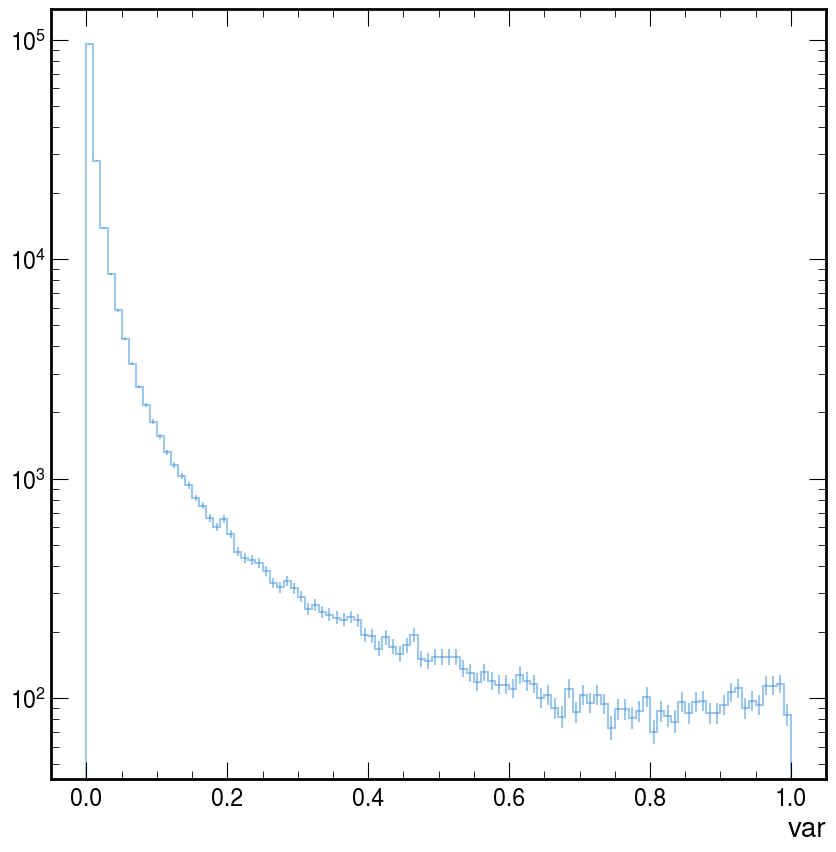

In [13]:
## Plot to show data labels look ok

plt.figure()

hist_axis = hist.axis.Regular(100, 0., 1., name='var', growth=False, underflow=False, overflow=False)

data_hists, data_plot_labels = [], []
if not EVAL_DATA_ON_ALL_FOLDS:
    
    for fold_idx in range(len(BDT_DATA_preds)):

        data_hists.append(
            hist.Hist(hist_axis, storage='weight').fill(
                var=np.array(BDT_DATA_preds[fold_idx])[:, 0],
            )
        )
        data_plot_labels.append(f"fold {fold_idx}")
else:

    data_hists.append(
        hist.Hist(hist_axis, storage='weight').fill(
            var=np.array(BDT_DATA_preds)[:, 0],
        )
    )
    data_plot_labels.append(f"sum over folds")

hep.histplot(
    data_hists,
    alpha=0.5, density=False, histtype='step',
    label=data_plot_labels
)

plt.yscale('log')
plt.show()

In [10]:
FORCE_REEVAL = True

# load and pre-process the data
VARIATIONS_FILEPATHS_DICT = {
    syst_name: get_filepath_dict(syst_name=syst_name) for syst_name in [
        'nominal',
        # 'Et_dependent_ScaleEB_up', 'Et_dependent_ScaleEB_down', 'Et_dependent_ScaleEE_up', 'Et_dependent_ScaleEE_down', 
        # 'Et_dependent_Smearing_up', 'Et_dependent_Smearing_down', 
        # 'jec_syst_Total_up', 'jec_syst_Total_down', 'jer_syst_up', 'jer_syst_down'
    ]
}

# load and pre-process the data
DATA_FILEPATHS_DICT = {
    'Data': [
        # 2022
        lpc_fileprefix+Run3_2022[:-4]+f"/data/DataC_2022/*merged.parquet",
        lpc_fileprefix+Run3_2022[:-4]+f"/data/DataD_2022/*merged.parquet",
        lpc_fileprefix+Run3_2022[:-4]+f"/data/Data_EraE/*merged.parquet",
        lpc_fileprefix+Run3_2022[:-4]+f"/data/Data_EraF/*merged.parquet",
        lpc_fileprefix+Run3_2022[:-4]+f"/data/Data_EraG/*merged.parquet",
        # 2023
        lpc_fileprefix+Run3_2023[:-4]+"/data/Data_EraCv1/*merged.parquet",
        lpc_fileprefix+Run3_2023[:-4]+"/data/Data_EraCv2/*merged.parquet",
        lpc_fileprefix+Run3_2023[:-4]+"/data/Data_EraCv3/*merged.parquet",
        lpc_fileprefix+Run3_2023[:-4]+"/data/Data_EraCv4/*merged.parquet",
        lpc_fileprefix+Run3_2023[:-4]+"/data/Data_EraDv1/*merged.parquet",
        lpc_fileprefix+Run3_2023[:-4]+"/data/Data_EraDv2/*merged.parquet",
        # 2024
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraB/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraC/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraD/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraE/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraF/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraG/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraH/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraI_v1/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma0_EraI_v2/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraB/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraC/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraD/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraE/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraF/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraG/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraH/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraI_v1/*merged.parquet",
        lpc_fileprefix+Run3_2024[:-4]+"/data/Data_EGamma1_EraI_v2/*merged.parquet",
    ],
}

# Sorts the predictions to map the output to the correct event
def sorted_preds(preds, data_aux, sample, sorted_preds=False, sort_variable='hash'):

    if np.size(np.unique(sample[sort_variable])) != np.size(sample[sort_variable]):
        raise Exception(f"The sort_variable you chose ({sort_variable}) does not have uniquely defined values for all events. This will cause sorting failures.")
    
    if not sorted_preds:
        flat_preds = np.concatenate([preds[fold_idx] for fold_idx in range(len(data_aux))])
        preds_sort = np.argsort(
            np.concatenate([data_aux[f"fold_{fold_idx}"].loc[:, sort_variable].to_numpy() for fold_idx in range(len(data_aux))])
        )
    else:
        flat_preds = preds
        preds_sort = np.arange(len(flat_preds))

    sample_sort = np.argsort(np.argsort(
        ak.to_numpy(sample[sort_variable], allow_missing=False)
    ))

    if np.any(
        np.concatenate(
            [data_aux[f"fold_{fold_idx}"].loc[:, sort_variable].to_numpy() for fold_idx in range(len(data_aux))]
        )[preds_sort][sample_sort] != ak.to_numpy(sample[sort_variable], allow_missing=False)
    ) and not sorted_preds:
        raise Exception(f"Sort failed.")

    return flat_preds[preds_sort][sample_sort]

def get_file_sample_name(dirpath: str, variation: str):
    end_idx = dirpath.find(variation) - 1
    start_idx = dirpath[:end_idx].rfind('/') + 1

    if end_idx == -2 or start_idx == 0: return ''

    return dirpath[start_idx:end_idx]

# dirpath_addition = '_MultiBDT_output_float32_22_23'
dirpath_addition = '_MultiBDT_output_mvaIDCorr_22_23'
filename_addition = '_MultiBDT_output'

## MC SAMPLES ##
# Load parquet files #
for i, sample_name in enumerate(order):

    for variation, variation_filepath_dict in VARIATIONS_FILEPATHS_DICT.items():

        for dirpath in variation_filepath_dict[sample_name]:

            if variation != 'nominal' and re.search('H', get_file_sample_name(dirpath, variation).upper()) is None: continue
            if re.search('Q', get_file_sample_name(dirpath, variation).upper()) is not None: continue

            print('======================== started \n', dirpath)
            parquet_filepath = glob.glob(dirpath)[0]
            dest_filepath = parquet_filepath[:parquet_filepath.find('Run3_202')+len('Run3_202x_merged')] + dirpath_addition + parquet_filepath[parquet_filepath.find('Run3_202')+len('Run3_202x_merged'):parquet_filepath.rfind('.')] + filename_addition + parquet_filepath[parquet_filepath.rfind('.'):]
            if not os.path.exists(dest_filepath[:dest_filepath.rfind('/')]):
                os.makedirs(dest_filepath[:dest_filepath.rfind('/')])
            elif not FORCE_REEVAL:
                print(f'file already exists at \n{dest_filepath}\n{"="*60}')
                continue

            if re.search('VBFHHto2B2G_CV_1_C2V_1_C3_1', parquet_filepath) is None: continue

            sample = ak.from_parquet(parquet_filepath)
            sample = sample[
                sample['is_nonRes']
                & sample['fiducialGeometricFlag']
            ]

            (
                NOTHING_IGNORE,
                IGNORE_data_df_dict, SAMPLE_data_test_df_dict, 
                IGNORE_data_hlf_dict, IGNORE_label_dict,
                SAMPLE_data_hlf_test_dict, SAMPLE_label_test_dict, 
                SAMPLE_hlf_vars_columns_dict,
                IGNORE_data_aux_dict, SAMPLE_data_test_aux_dict
            ) = process_data(
                {"sample": [parquet_filepath]}, OUTPUT_DIRPATH, order=['sample'], mod_vals=MOD_VALS, k_fold_test=True,
                save=False, std_json_dirpath=OUTPUT_DIRPATH
            )

            sample_preds = []
            for fold_idx in range(len(SAMPLE_data_test_df_dict)):
                
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    
                    booster = xgb.Booster(param)
                    booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

                    bdt_test_sample_dict = xgb.DMatrix(
                        data=SAMPLE_data_hlf_test_dict[f"fold_{fold_idx}"], label=SAMPLE_label_test_dict[f"fold_{fold_idx}"], 
                        missing=-999.0, feature_names=list(SAMPLE_hlf_vars_columns_dict[f"fold_{fold_idx}"])
                    )

                    sample_preds.append(
                        booster.predict(
                            bdt_test_sample_dict, 
                            iteration_range=(0, booster.best_iteration+1)
                        )
                    )

            sample['MultiBDT_output'] = sorted_preds(
                sample_preds, SAMPLE_data_test_aux_dict, sample
            )

            merged_parquet = ak.to_parquet(sample, dest_filepath)
            del sample
            print('======================== finished \n', dest_filepath)

## DATA ##
# for dirpath in DATA_FILEPATHS_DICT['Data']:

#     print('======================== started \n', dirpath)
#     parquet_filepath = glob.glob(dirpath)[0]
#     dest_filepath = parquet_filepath[:parquet_filepath.find('Run3_202')+len('Run3_202x_merged')] + dirpath_addition + parquet_filepath[parquet_filepath.find('Run3_202')+len('Run3_202x_merged'):parquet_filepath.rfind('.')] + filename_addition + parquet_filepath[parquet_filepath.rfind('.'):]
#     if not os.path.exists(dest_filepath[:dest_filepath.rfind('/')]):
#         os.makedirs(dest_filepath[:dest_filepath.rfind('/')])
#     elif not FORCE_REEVAL:
#         print(f'file already exists at \n{dest_filepath}\n{"="*60}')
#         continue
    
#     data_sample = ak.from_parquet(parquet_filepath)
#     data_sample = data_sample[
#         data_sample['nonRes_has_two_btagged_jets'] 
#         & data_sample['is_nonRes']
#         & data_sample['pass_fiducial_geometric']
#     ]

#     (
#         NOTHING_IGNORE,
#         DATA_data_df_dict, DATA_data_test_df_dict, 
#         DATA_data_hlf_dict, DATA_label_dict,
#         DATA_data_hlf_test_dict, DATA_label_test_dict, 
#         DATA_hlf_vars_columns_dict,
#         DATA_data_aux_dict, DATA_data_test_aux_dict
#     ) = process_data(
#         {"sample": [parquet_filepath]}, OUTPUT_DIRPATH, order=['sample'], mod_vals=MOD_VALS, k_fold_test=True,
#         save=False, std_json_dirpath=OUTPUT_DIRPATH
#     )

#     bdt_train_data_dict = xgb.DMatrix(
#         data=DATA_data_hlf_dict[f"fold_0"], label=DATA_label_dict[f"fold_0"], 
#         missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_0"])
#     )
#     bdt_test_data_dict = xgb.DMatrix(
#         data=DATA_data_hlf_test_dict[f"fold_0"], label=DATA_label_test_dict[f"fold_0"], 
#         missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_0"])
#     )

#     test_preds = []
#     for fold_idx in range(len(DATA_label_test_dict)):

#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")

#             booster = xgb.Booster(param)
#             booster.load_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))

#             # all-fold eval
#             BDT_train_preds = booster.predict(
#                 bdt_train_data_dict, 
#                 iteration_range=(0, booster.best_iteration+1)
#             )
#             BDT_test_preds = booster.predict(
#                 bdt_test_data_dict, 
#                 iteration_range=(0, booster.best_iteration+1)
#             )

#             BDT_all_preds = np.concatenate([BDT_train_preds, BDT_test_preds])
#             BDT_all_preds = BDT_all_preds[
#                 np.argsort(
#                     np.concatenate([DATA_data_aux_dict[f"fold_0"].loc[:, 'hash'].to_numpy(), DATA_data_test_aux_dict[f"fold_0"].loc[:, 'hash'].to_numpy()])
#                 )
#             ]

#             if fold_idx == 0:
#                 data_preds = copy.deepcopy(BDT_all_preds)
#             else:
#                 data_preds += BDT_all_preds

#                 if fold_idx == len(DATA_label_test_dict) - 1:
#                     data_preds = data_preds / len(DATA_label_test_dict)


#             # single-fold eval
#             bdt_test_data_fold = xgb.DMatrix(
#                 data=DATA_data_hlf_test_dict[f"fold_{fold_idx}"], label=DATA_label_test_dict[f"fold_{fold_idx}"], 
#                 missing=-999.0, feature_names=list(DATA_hlf_vars_columns_dict[f"fold_{fold_idx}"])
#             )

#             test_preds.append(
#                 booster.predict(
#                     bdt_test_data_fold,
#                     iteration_range=(0, booster.best_iteration+1)
#                 )
#             )

#     data_sample['MultiBDT_output'] = sorted_preds(
#         data_preds, DATA_data_test_aux_dict, data_sample,
#         sorted_preds=True
#     )
#     data_sample['MultiBDT_output_mod5'] = sorted_preds(
#         test_preds, DATA_data_test_aux_dict, data_sample
#     )

#     merged_parquet = ak.to_parquet(data_sample, dest_filepath)
#     del data_sample
#     print('======================== finished \n', dest_filepath)

======================== started 
 /eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v2/Run3_2022_merged/sim/preEE/GluGlutoHHto2B2G_kl_1p00_kt_1p00_c2_0p00/nominal/*merged.parquet
======================== started 
 /eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v2/Run3_2022_merged/sim/postEE/GluGluToHH/nominal/*merged.parquet
======================== started 
 /eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v2/Run3_2023_merged/sim/preBPix/GluGlutoHHto2B2G_kl-1p00_kt-1p00_c2-0p00/nominal/*merged.parquet
======================== started 
 /eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v2/Run3_2023_merged/sim/postBPix/GluGlutoHHto2B2G_kl-1p00_kt-1p00_c2-0p00/nominal/*merged.parquet
======================== started 
 /eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v2/Run3_2022_merged/sim/preEE/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*merged.parquet
[15:45:26] WARNING: /home/conda/feedstock_root/build_artifacts

IndexError: list index out of range